## Configuring the workspace
Assicurarsi di aver installato tutti le librerie necessarie per eseguire gli script all'interno del notebook

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Creo la cartella data per salvare i dataset
if not os.path.exists("data"):
    os.makedirs("data")

os.chdir("data")

### Functions developed by Prof. Veronica Guidetti

#### qq-plot

In [2]:
## TAKEN FROM https://stats.stackexchange.com/questions/403652/two-sample-quantile-quantile-plot-in-python
## Solution provided by user: Artem Mavrin
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    import numbers
    import numpy as np
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    minimum=np.min([np.min(x),np.min(y)])
    maximum=np.max([np.max(x),np.max(y)])

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    ax.axline([minimum, minimum], [maximum, maximum], color='k')

#### Ordinal to numerical attribute

In [3]:
def ordinal_to_numeric(df, mappings):
    """
    Convert ordinal string values in a DataFrame to numerical ordered values and rescale between 0 and 1 based on the number of different values in the mappings.

    Parameters:
        df (DataFrame): The pandas DataFrame containing ordinal string values.
        mappings (dict): A dictionary where keys are column names and values are dictionaries mapping ordinal string values to numerical ordered values.

    Returns:
        DataFrame: A new DataFrame with ordinal string values replaced by rescaled numerical ordered values.
    """
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    df_copy = df.copy()

    # Map ordinal string values to numerical ordered values for each column
    for col, mapping in mappings.items():
        if col in df_copy.columns:
            df_copy[col] = pd.to_numeric(df_copy[col].map(mapping))
            # Rescale the numerical values between 0 and 1
            num_values = len(mapping)
            df_copy[col] = df_copy[col] / (num_values - 1)  # Rescale between 0 and 1

    return df_copy

#### Dissimilarity matrix

In [4]:
from scipy.spatial.distance import euclidean,jaccard

def nominal_distance(x, y):
    p = len(x)
    m = sum(1 if a == b else 0 for a, b in zip(x, y))
    return float(p - m) / p

def symmetric_binary_distance(arr1, arr2):
    """
    Compute the symmetric binary distance between two binary arrays.

    Parameters:
        arr1 (array-like): The first binary array.
        arr2 (array-like): The second binary array.

    Returns:
        float: The symmetric binary distance.
    """
    # Compute the contingency table
    ct = [[0, 0], [0, 0]]
    for a, b in zip(arr1, arr2):
        ct[a][b] += 1

    # Compute the symmetric binary distance
    numerator = ct[0][1] + ct[1][0]
    denominator = sum(sum(row) for row in ct)
    distance = numerator / denominator

    return distance



def dissimilarity_matrix(df,dict_types):
    '''
    This function computes a dissimilarity matrix based on the input DataFrame df
    containing records with attributes of various types. The dissimilarity matrix
    quantifies the dissimilarity or distance between pairs of records in the DataFrame.

    Inputs:
    - df: DataFrame. Input DataFrame containing records with attributes of various types.
    - dict_types: Dictionary. A dictionary specifying the types of attributes in
                  the DataFrame columns. The keys represent column names, and the
                  values represent the types of attributes. These types determine
                  the distance function used to compute dissimilarity.
                  The types can be one of the following:
                  'NO': Nominal
                  'NU': Numerical
                  'SB': Symmetric Binary
                  'AB': Asymmetric Binary
    Returns:
    - dissimilarity_matrix: DataFrame. The computed dissimilarity matrix represented
                            as a DataFrame. The dissimilarity matrix provides pairwise
                            dissimilarity values between records in the input DataFrame.
                            The matrix is symmetric, where the element at row i and
                            column j represents the dissimilarity between record i and record j.
    '''

    num_records = df.shape[0]
    dissimilarity_matrix = np.zeros((num_records, num_records))

    # Define distance functions for different attribute types
    distance_functions = {
        'NO': nominal_distance,
        'NU': euclidean,
        'SB': symmetric_binary_distance,
        'AB': jaccard,
    }


    # Compute upper triangular part of dissimilarity matrix
    for i in range(num_records):
        print(f'Record {i}/{num_records}')

        for j in range(i+1, num_records):
            dissimilarity = 0
            num_valid_elements = 0
            for col in dict_types.keys():
                if (pd.notna(df[col].iloc[i]) and pd.notna(df[col].iloc[j])):
                    distance_func = distance_functions[dict_types[col]]
                    dissimilarity += distance_func([df[col].iloc[i]], [df[col].iloc[j]])
                    if dict_types[col]!='AB' or (df[col].iloc[i]==1 or df[col].iloc[j]==1):
                        num_valid_elements += 1
            if num_valid_elements > 0:
                dissimilarity_matrix[i, j] = dissimilarity / num_valid_elements  # Take the mean dissimilarity
            else:
                dissimilarity_matrix[i, j] = np.nan

    # Mirror upper triangular part to obtain complete symmetric matrix
    dissimilarity_matrix += dissimilarity_matrix.T - np.diag(dissimilarity_matrix.diagonal())

    return pd.DataFrame(dissimilarity_matrix, index=df.index, columns=df.index)

# Heart Failure Prediction Dataset
Le malattie cardiovascolari (CVD) sono la prima causa di morte a livello globale, con circa 17,9 milioni di vite all'anno, pari al 31% di tutti i decessi nel mondo. Quattro decessi su 5 per CVD sono dovuti ad attacchi di cuore e ictus, e un terzo di questi decessi avviene prematuramente in persone di età inferiore ai 70 anni. L'insufficienza cardiaca è un evento comune causato da CVD e questo set di dati contiene 11 caratteristiche che possono essere utilizzate per prevedere una possibile malattia cardiaca.

Le persone affette da malattie cardiovascolari o ad alto rischio cardiovascolare (per la presenza di uno o più fattori di rischio come ipertensione, diabete, iperlipidemia o malattie già conclamate) hanno bisogno di una diagnosi e di una gestione precoci, per le quali un modello di apprendimento automatico può essere di grande aiuto.

In [5]:
if not os.path.exists("heart.csv"):
    # Download the dataset
    !kaggle datasets download -d fedesoriano/heart-failure-prediction
    !unzip heart-failure-prediction.zip

In [6]:
df = pd.read_csv("heart.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


**Attributi del Dataset**
- Age: età del paziente [anni]
- Sex: sesso del paziente 
    - M: Maschio
    - F: Femmina
- ChestPainType: tipo di dolore toracico 
    - TA: Angina* Tipica
    - ATA: Angina Atipica
    - NAP: Dolore Non Anginoso
    - ASY: Asintomatico
- RestingBP: pressione sanguigna a riposo [mm Hg]
- Cholesterol: colesterolo sierico [mg/dl]
- FastingBS: glicemia a digiuno 
    - 1: se FastingBS > 120 mg/dl
    - 0: altrimenti
- RestingECG: risultati dell'elettrocardiogramma a riposo 
    - Normal: Normale
    - ST: presenza di anomalia dell'onda ST-T (inversioni dell'onda T e/o elevazione o depressione del segmento ST di > 0,05 mV)
    - LVH: mostra probabile o definita ipertrofia ventricolare sinistra secondo i criteri di Estes
- MaxHR: frequenza cardiaca massima raggiunta [valore numerico tra 60 e 202]
- ExerciseAngina: angina* indotta da esercizio 
    - Y: Sì
    - N: No
- Oldpeak: oldpeak = ST [valore numerico misurato in depressione]
- ST_Slope: inclinazione del segmento ST durante l'esercizio 
    - Up: inclinato verso l'alto
    - Flat: piatto
    - Down: inclinato verso il basso
- HeartDisease: classe di uscita 
    - 1: malattia cardiaca
    - 0: Normale

_*Il termine Angina Pectoris deriva dai termini latini Angina=dolore e Pectoris=petto. Si tratta, in effetti, di una sindrome caratterizzata da dolore in regione retrosternale, talvolta irradiato al lato ulnare del braccio sinistro e alle spalle. [wiki](https://www.my-personaltrainer.it/cardiopatia-ischemica/angina.html)_

In [8]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [9]:
categorical = [
    "Sex",
    "ChestPainType",
    "FastingBS",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
]

Possiamo notare che il dataset sembra essere leggermente sbilanciato sugli esempi negativi, con i pazienti affetti da malattia cardiaca.  
Questo potrebbe essere un bene perchè il predittore sarà più preciso nella predizione del caso negativo.

<Axes: xlabel='HeartDisease', ylabel='count'>

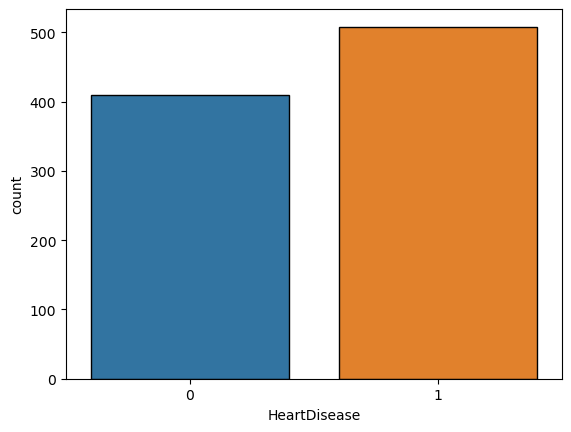

In [10]:
sns.countplot(df, x="HeartDisease", edgecolor="black", hue="HeartDisease", legend=False)

Facendo una panoramica su tutti gli attributi categorici, possiamo notare che:
- Il dataset contiene molti più maschi.
- Molti pazienti sono asintomatici rispetto ai dolori al petto
- Molti non hanno problemi di glicemia a digiuno
- Molti hanno un elettrocardiogramma apparentemente normale
- La maggior parte delle persone è asintomatica al dolore anche durante l'esercizio fisico
- Sempre durante l'esercizio fisico, abbiamo pochi casi con il segmento ST basso

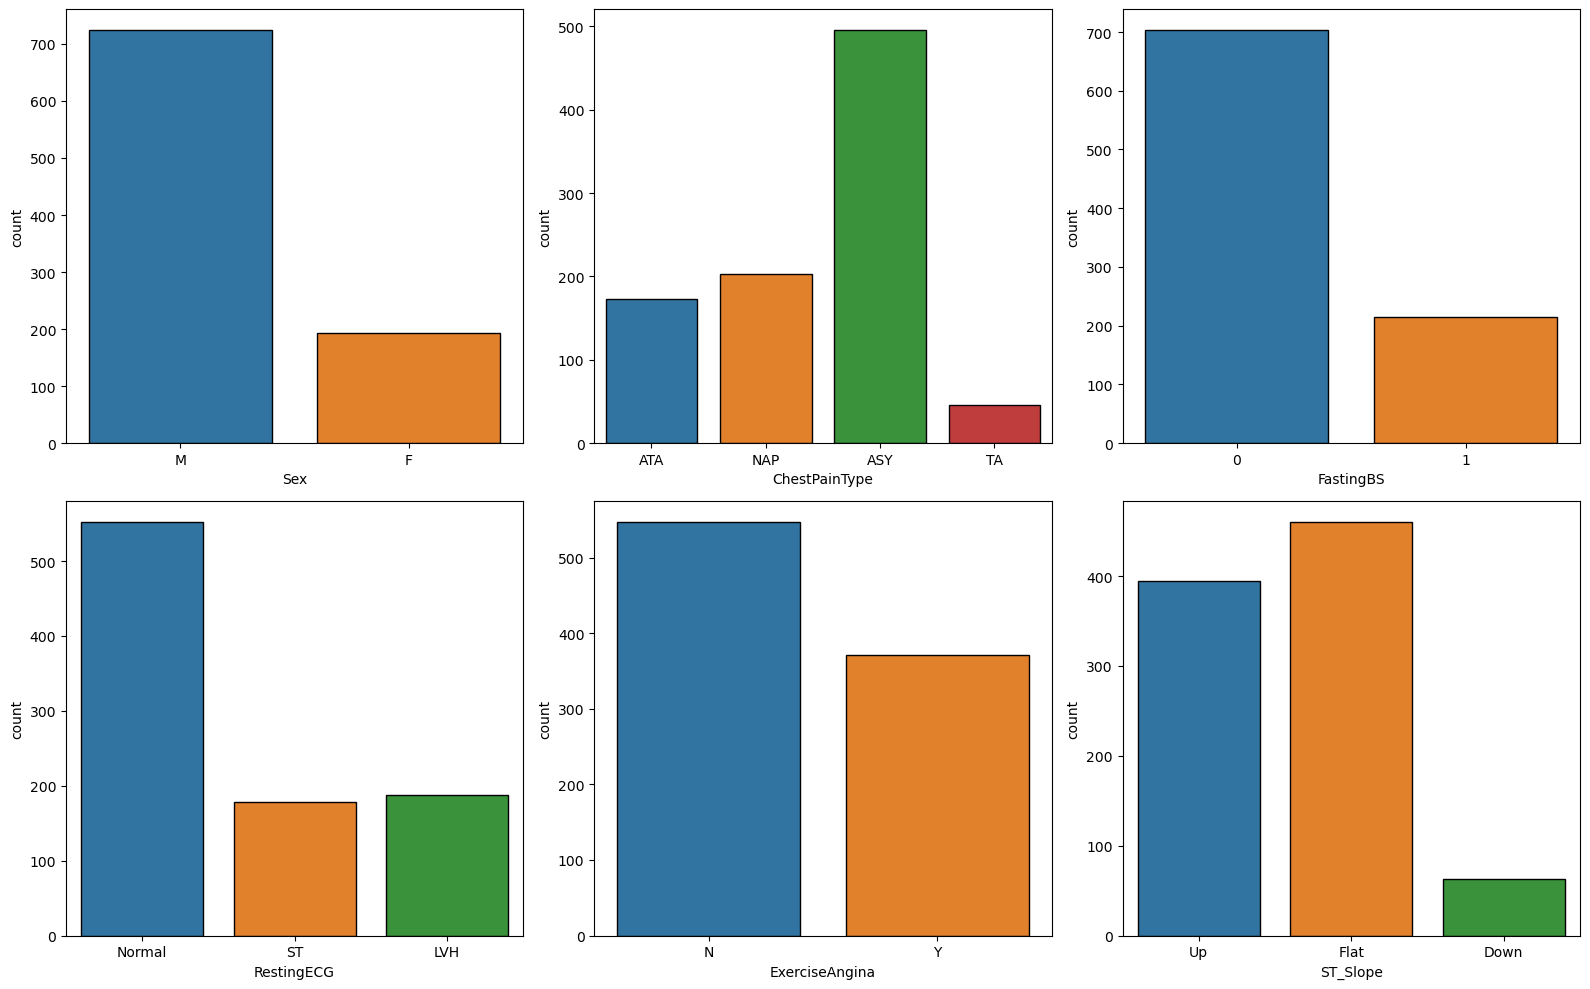

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(categorical):
    sns.countplot(
        df, x=col, ax=axs[i // 3, i % 3], edgecolor="black", hue=col, legend=False
    )
plt.tight_layout()

In [12]:
numerical = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

Dando un'occhiata alle distribuzioni degli attributi numerici, notiamo che:
- L'età ben distribuita con qualche picco, ma niente di anomalo
- La pressione sangiugna a di sicuro qualche outlier e anche vari picchi strani, ma la forma rimane comunque unimodale
- Il colesterolo ha tanti pazienti con valore zero, il che è abbastanza strano
- La frequenza cardiaca massima ha una buona distribuzione, forse leggermente bimodale
- Il valore di Oldpeak sembra che abbia degli outlier e molti pazienti con il valore 0

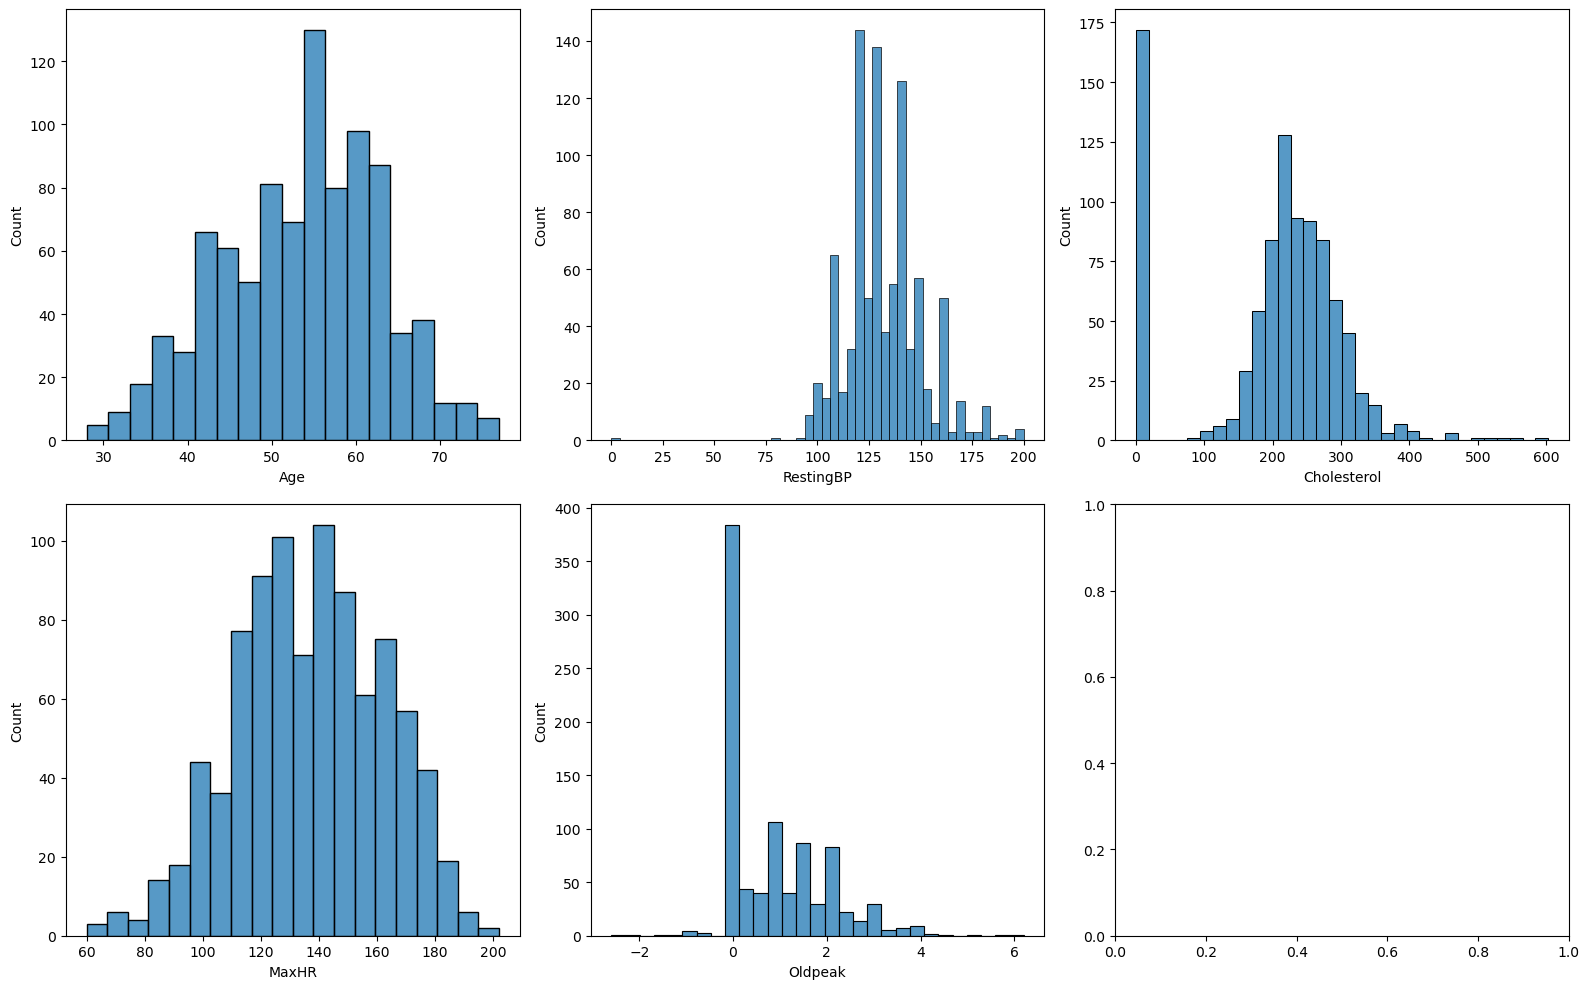

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.histplot(df, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

Di seguito possiamo notare la forma delle varie distribuzioni.

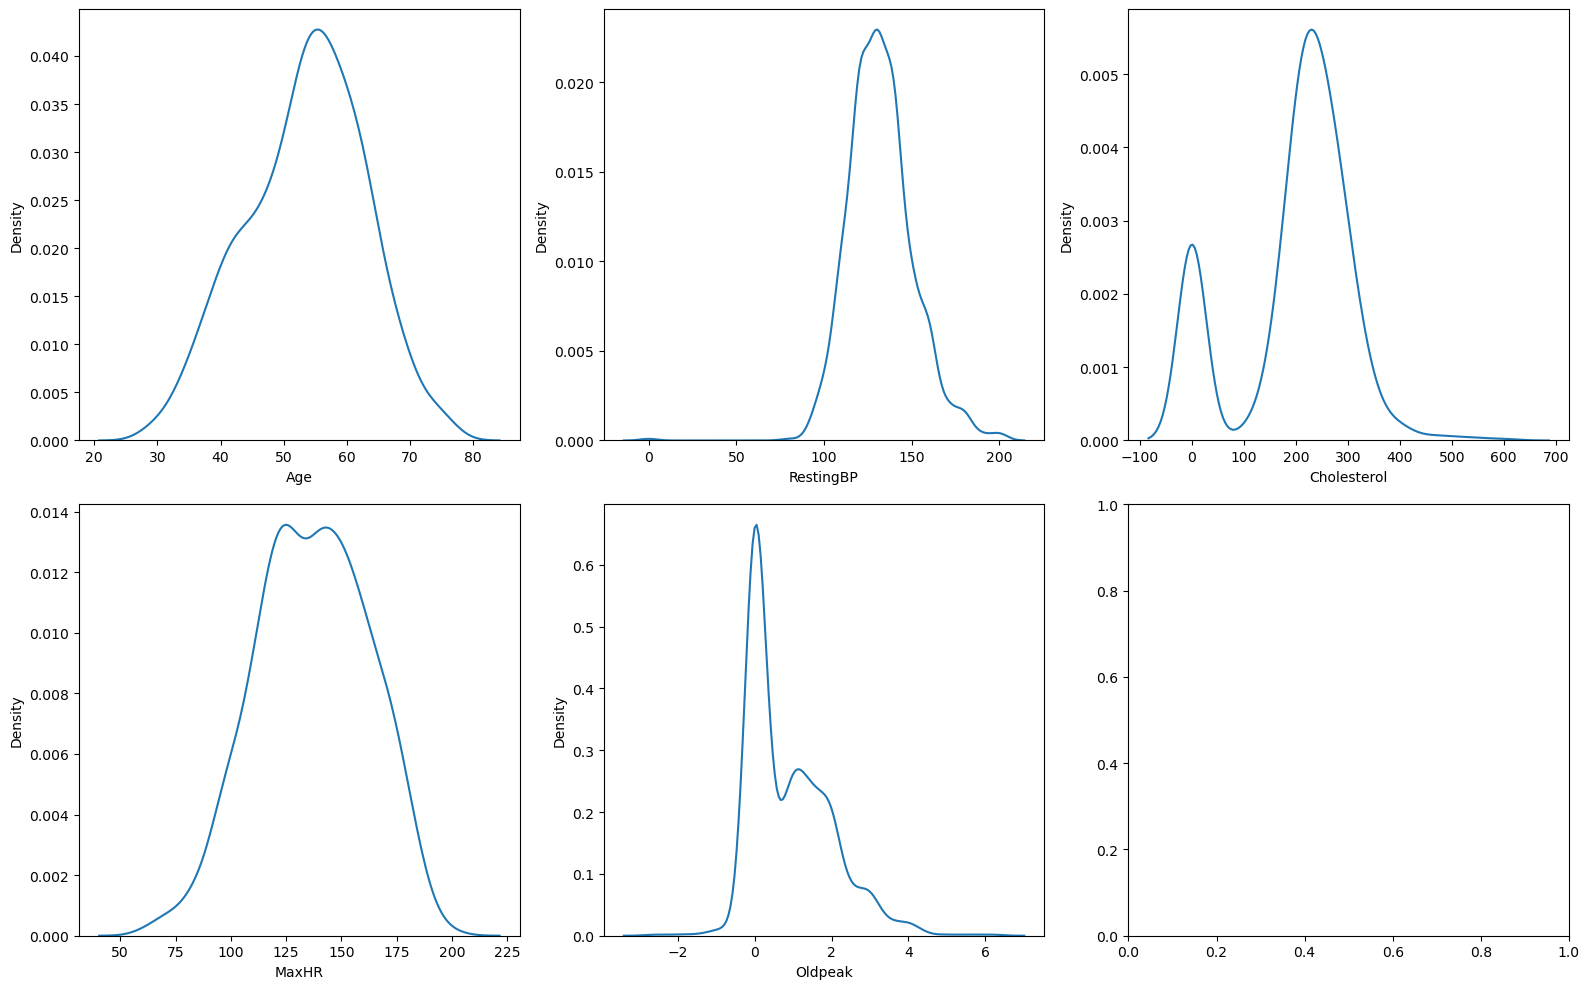

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.kdeplot(df, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

# Analisi Valori mancanti

In [15]:
# Apparentemente sembra che non ci siano valori mancanti
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [16]:
# Andando a guardere però i valori pari a 0, notiamo alcune anomalie
df[numerical].where(df[numerical] == 0).count()

Age              0
RestingBP        1
Cholesterol    172
MaxHR            0
Oldpeak        368
dtype: int64

Di seguito, le valutazioni correlate:
- La __pressione sanguigna__ ha un paziente con il valore 0, il che sembra una misurazione errata.
- Alcuni pazienti hanno il __colesterolo__ pari a 0, il che è impossibile.
- Tanti pazienti hanno questo valore di Oldpeak pari a 0 che però può essere un valore accettabile: indica una sorta di depressione toracica nulla e quindi nella norma.  
_Forse si potrebbe valutare comunque come una misurazione errata perchè sembra strano che tanti pazienti abbiano la depressione toracica identica._   
_D'altro canto si potrebbe dare la motivazione alla misurazione poco precisa e quindi lo strumente potrebbe non aver colto le leggere differenze tra i pazienti._

In conclusione è stato deciso di considerare i valori 0 come valori mancanti per gli attributi RestingBP e Cholesterol.  
Per l'attributo Oldpeak considerò i valori 0 come un paziente avente una depressione toracica nella norma. Anche perchè altrimenti avrei dovuto lavorare con metà del dataset.

In [17]:
# Infatti il valore minimo di colesterolo dopo lo zero, è abbastanza lontano dallo zero
df[(df["Cholesterol"] > 0) & (df["Cholesterol"] < 100)]["Cholesterol"]

98    85
Name: Cholesterol, dtype: int64

Consideriamo quindi il dataset senza questi valori mancanti, per essere sicuri delle valutazioni che faremo

In [18]:
col_with_zeros = ["Cholesterol", "RestingBP"]
df_clean = df.copy()
df_clean[col_with_zeros] = df_clean[col_with_zeros].replace(0, np.nan)
df_clean.dropna(inplace=True)
print(f"Numero di righe prima: {df.shape[0]}")
print(f"Numero di righe dopo: {df_clean.shape[0]}")
df_clean.describe()

Numero di righe prima: 918
Numero di righe dopo: 746


Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  746.000000  746.000000   746.000000  746.000000  746.000000   
mean    52.882038  133.022788   244.635389    0.167560  140.226542   
std      9.505888   17.282750    59.153524    0.373726   24.524107   
min     28.000000   92.000000    85.000000    0.000000   69.000000   
25%     46.000000  120.000000   207.250000    0.000000  122.000000   
50%     54.000000  130.000000   237.000000    0.000000  140.000000   
75%     59.000000  140.000000   275.000000    0.000000  160.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  746.000000    746.000000  
mean     0.901609      0.477212  
std      1.072861      0.499816  
min     -0.100000      0.000000  
25%      0.000000      0.000000  
50%      0.500000      0.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

Notiamo subito che il dataset probabilmente era stato gonfiato per creare più casi di malattie cardiache.  
Infatti il dataset senza valori mancanti è più bilanciato con leggermente più pazienti sani.

<Axes: xlabel='HeartDisease', ylabel='count'>

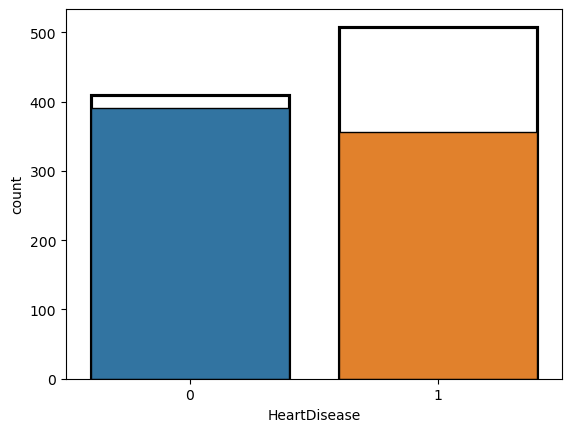

In [19]:
sns.countplot(df, x="HeartDisease", fill=False, edgecolor="black")
sns.countplot(
    df_clean, x="HeartDisease", hue="HeartDisease", edgecolor="black", legend=False
)

Per ogni attributo categorico possiamo dire:
- Molti pazienti con valori mancanti era maschio, quindi diminuisce la differenza di frequenza tra genere che rimane comunque abbastanza marcata.
- Diminuiscono gli asintomatici rispetto al dolore al petto
- I problemi di glicemia sono rimasti invariati
- Diminuiscono i pazienti con elettrocardiogramma normale
- Diminuiscono gli asintomatici da dolore al petto durante l'esercizio
- Il segmento ST rimane invariato

Dopo queste considerazioni, possiamo ipotizzare che il dataset possa essere stato sovracampionato (oversampling) di pazienti con malattie al cuore asintomatiche.

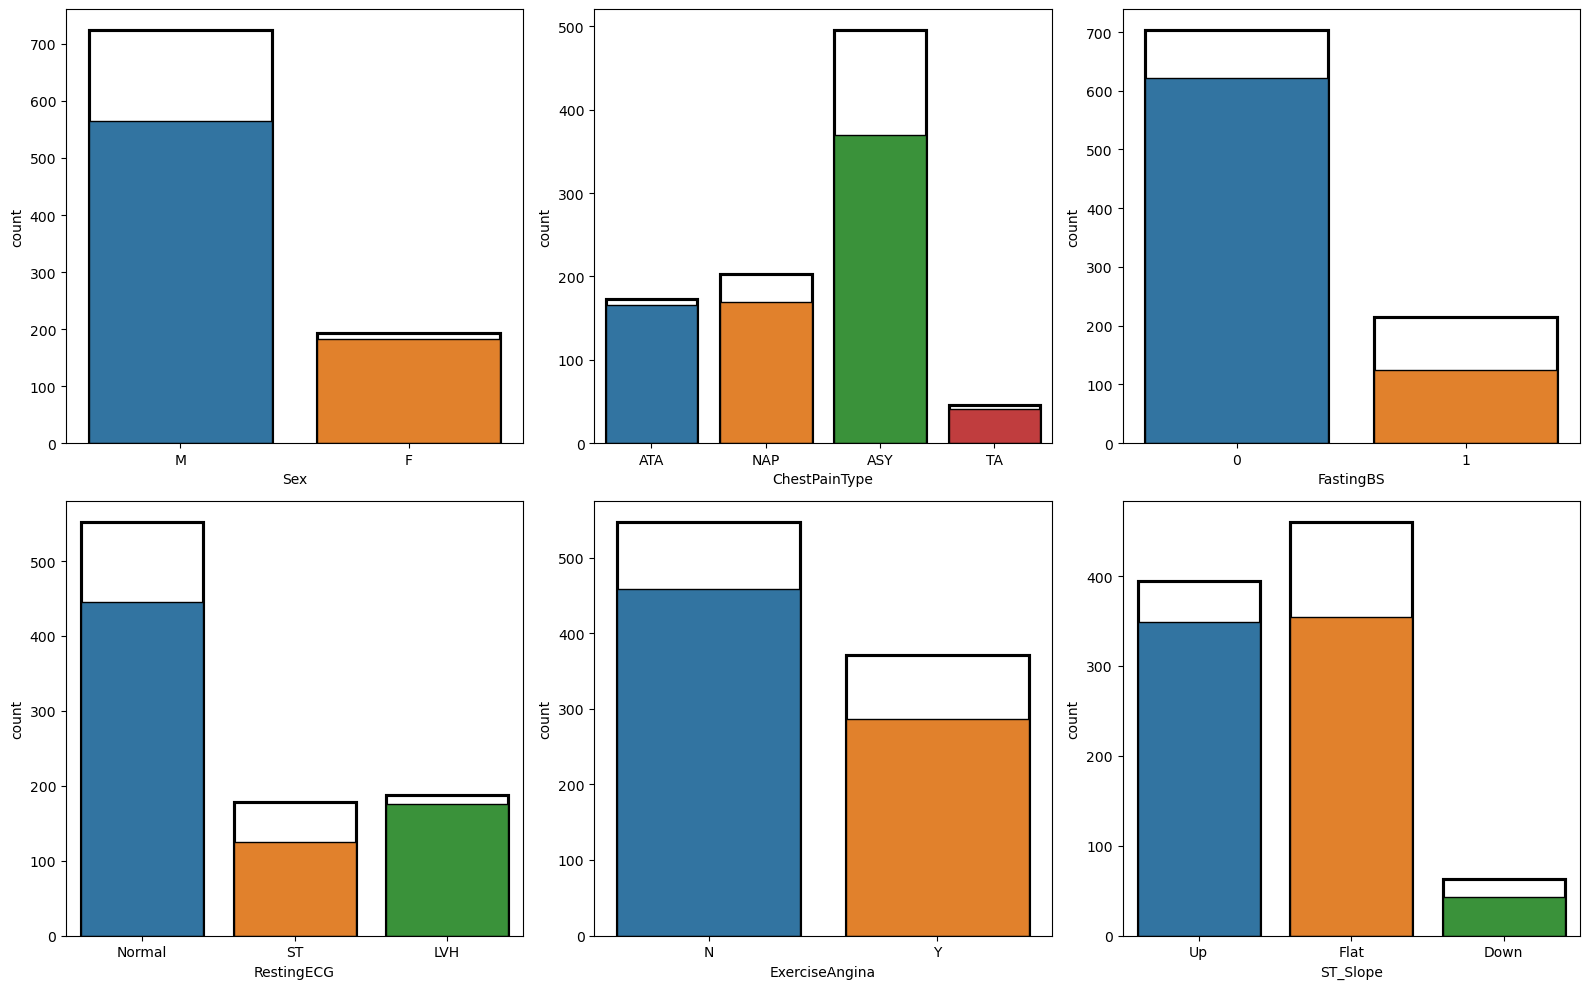

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(categorical):
    sns.countplot(df, x=col, ax=axs[i // 3, i % 3], fill=False, edgecolor="black")
    sns.countplot(
        df_clean,
        x=col,
        ax=axs[i // 3, i % 3],
        edgecolor="black",
        hue=col,
        legend=False,
    )
plt.tight_layout()

Ad occhio sembra che le distribuzioni dei vari attributi numerici siano diventate più compatte, cone meno picchi o comunque meno accentuati.

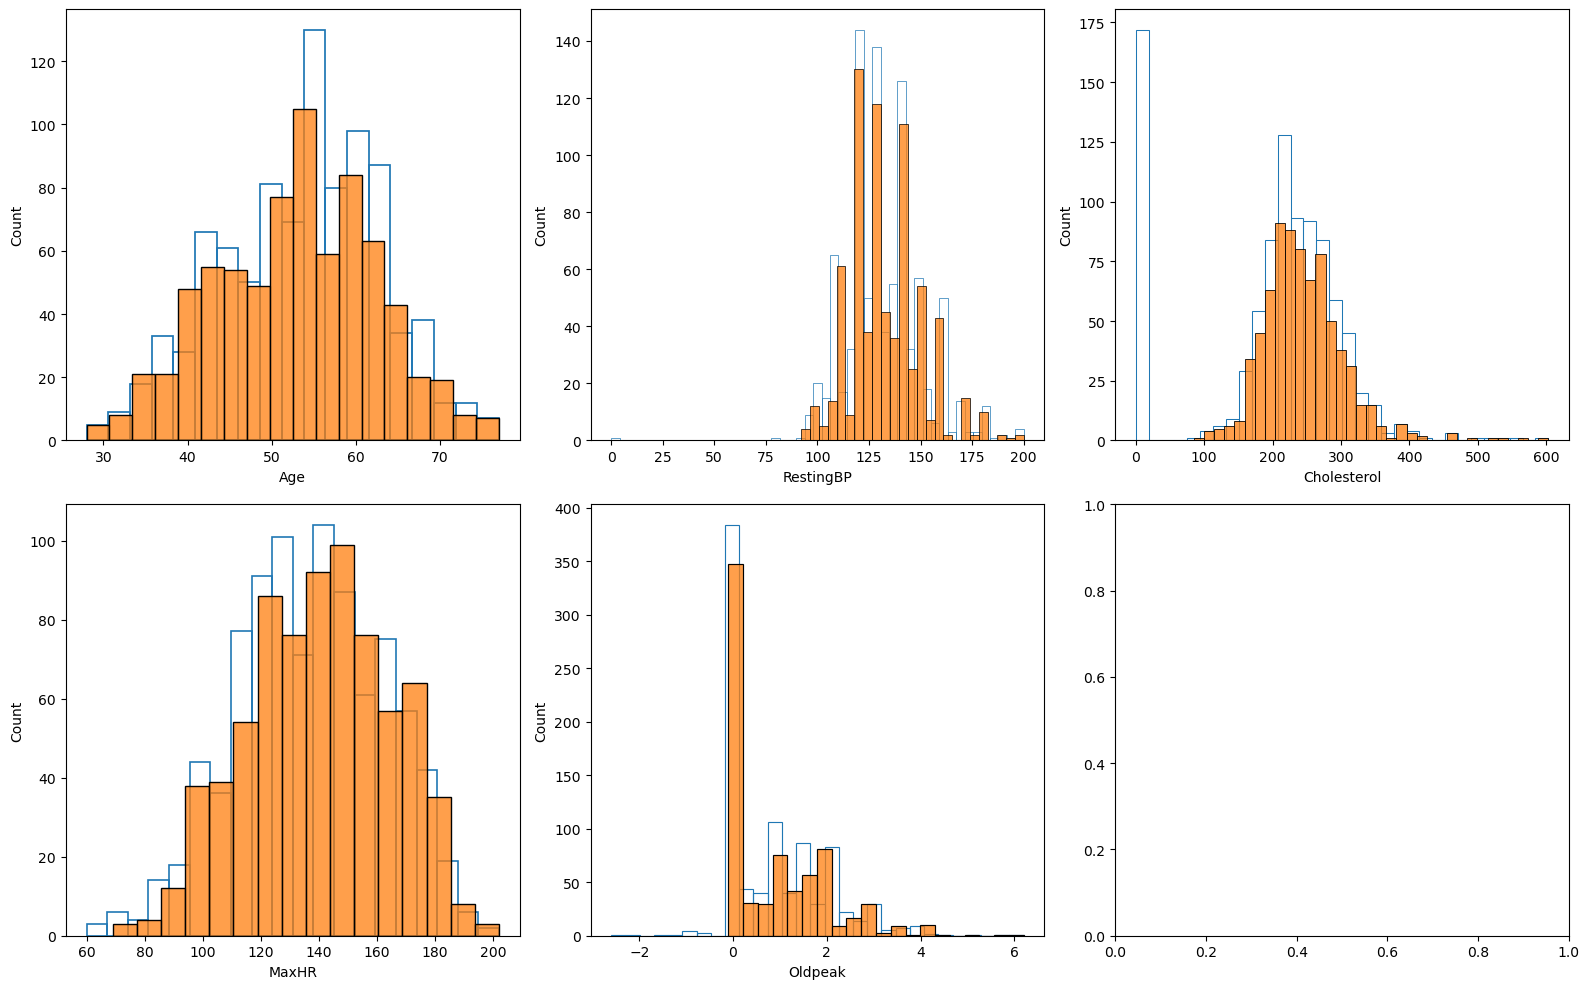

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.histplot(df, x=col, fill=False, ax=axs[i // 3, i % 3])
    sns.histplot(df_clean, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

Diciamo che la forma delle distribuzioni diventano più normali, tranne l'attributo di OldPeak che ha tanti valori pari a 0.

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.kdeplot(df, x=col, fill=False, ax=axs[i // 3, i % 3])
    sns.kdeplot(df_clean, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

# Misure di centralità e dispersione
Come misure di centralità sono state scelte la moda per gli attributi categorici.  
Possiamo notare che la maggior parte dei paziente sembrano non riscontrare sintomi negativi guardando solo gli attributi categorici.

In [23]:
# Per gli attributi categorici usiamo la moda come misura di centralità

print(f"La moda per la variabile Sex è {df_clean['Sex'].mode()[0]}")
print(f"La moda per la variabile ChestPainType è {df_clean['ChestPainType'].mode()[0]}")
print(f"La moda per la variabile FastingBS è {df_clean['FastingBS'].mode()[0]} (non diabetico)")
print(f"La moda per la variabile RestingECG è {df_clean['RestingECG'].mode()[0]}")
print(
    f"La moda per la variabile ExerciseAngina è {df_clean['ExerciseAngina'].mode()[0]} (non sofferente durante l'esercizio)"
)
print(f"La moda per la variabile ST_Slope è {df_clean['ST_Slope'].mode()[0]}")
print(f"La moda per la variabile HeartDisease è {df_clean['HeartDisease'].mode()[0]} (non malato)\n")

La moda per la variabile Sex è M
La moda per la variabile ChestPainType è ASY
La moda per la variabile FastingBS è 0 (non diabetico)
La moda per la variabile RestingECG è Normal
La moda per la variabile ExerciseAngina è N (non sofferente durante l'esercizio)
La moda per la variabile ST_Slope è Flat
La moda per la variabile HeartDisease è 0 (non malato)



Per gli attributi numerici usiamo di base la mediana, essendo un valore più robusto, e la confrontiamo con la media per capire se possiamo utilizzare la deviazione standard come misura di dispersione.  
Si può notare che la mediana risulta vicina alla media di quasi tutte le distribuzione, a differenza del colesterolo (poca varianza) e OldPeak (per quel il valore 0 molto frequente)  
In generale il dataset comprende tante persone dopo la mezza età e con dei valori a rischio di malattie cardiache guardando i range IQR, per esempio:
- La pressione del sangue oltre 130 mm Hg è considerata troppo elevata da un [articolo dell'università di Harvard](https://www.health.harvard.edu/heart-health/reading-the-new-blood-pressure-guidelines)
- Generalmente è una buona cosa tenere il colesterolo sotto i 200 mg/dl racconta questo [articolo dell'università di Harvard](https://www.health.harvard.edu/heart-health/making-sense-of-cholesterol-tests)

In [24]:
# Per gli attributi numerici usiamo la mediana come misura di centralità
print(f"Variabile AGE:")
print(f"\tLa mediana è {df_clean['Age'].median()}")
print(f"\tLa media è {round(df_clean['Age'].mean(),2)}")
print(f"\tIl range IQR è [{df_clean['Age'].quantile(0.25)} - {df_clean['Age'].quantile(0.75)}]")
print(f"\tLa deviazione standard è {round(df_clean['Age'].std(),2)}\n")

print(f"Variabile RestingBP:")
print(f"\tLa mediana è {df_clean['RestingBP'].median()}")
print(f"\tLa media è {round(df_clean['RestingBP'].mean(),2)}")
print(f"\tIl range IQR è [{df_clean['RestingBP'].quantile(0.25)} - {df_clean['RestingBP'].quantile(0.75)}]")
print(f"\tLa deviazione standard è {round(df_clean['RestingBP'].std(),2)}\n")

print(f"Variabile Cholesterol:")
print(f"\tLa mediana è {df_clean['Cholesterol'].median()}")
print(f"\tLa media è {round(df_clean['Cholesterol'].mean(),2)} (poco robusta)")
print(f"\tIl range IQR è [{df_clean['Cholesterol'].quantile(0.25)} - {df_clean['Cholesterol'].quantile(0.75)}]")
print(f"\tLa deviazione standard è {round(df_clean['Cholesterol'].std(),2)} (poco significativa)\n")

print(f"Variabile MaxHR:")
print(f"\tLa mediana è {df_clean['MaxHR'].median()}")
print(f"\tLa media è {round(df_clean['MaxHR'].mean(),2)}")
print(f"\tIl range IQR è [{df_clean['MaxHR'].quantile(0.25)} - {df_clean['MaxHR'].quantile(0.75)}]")
print(f"\tLa deviazione standard è {round(df_clean['MaxHR'].std(),2)}\n")

print(f"Variabile Oldpeak:")
print(f"\tLa mediana è {df_clean['Oldpeak'].median()}")
print(f"\tLa media è {round(df_clean['Oldpeak'].mean(),2)} (poco robusta)")
print(f"\tIl range IQR è [{df_clean['Oldpeak'].quantile(0.25)} - {df_clean['Oldpeak'].quantile(0.75)}]")
print(f"\tLa deviazione standard è {round(df_clean['Oldpeak'].std(),2)} (poco significativa)")


Variabile AGE:
	La mediana è 54.0
	La media è 52.88
	Il range IQR è [46.0 - 59.0]
	La deviazione standard è 9.51

Variabile RestingBP:
	La mediana è 130.0
	La media è 133.02
	Il range IQR è [120.0 - 140.0]
	La deviazione standard è 17.28

Variabile Cholesterol:
	La mediana è 237.0
	La media è 244.64 (poco robusta)
	Il range IQR è [207.25 - 275.0]
	La deviazione standard è 59.15 (poco significativa)

Variabile MaxHR:
	La mediana è 140.0
	La media è 140.23
	Il range IQR è [122.0 - 160.0]
	La deviazione standard è 24.52

Variabile Oldpeak:
	La mediana è 0.5
	La media è 0.9 (poco robusta)
	Il range IQR è [0.0 - 1.5]
	La deviazione standard è 1.07 (poco significativa)


## Misure di dispersione in relazione alla variabile target

Guardando il plot dei range IQR in relazione alla variabile target, possiamo dire si ammalano: 
- I più anziani
- Chi ha la pressione sanguigna più alta
- Il colesterolo mediamente più alto (come detto prima, la maggior parte dei pazienti del dataset ha problemi di colesterolo alto)
- Chi ha una frequenza cardiaca massima non troppo alta
- Chi ha una depressione toracica

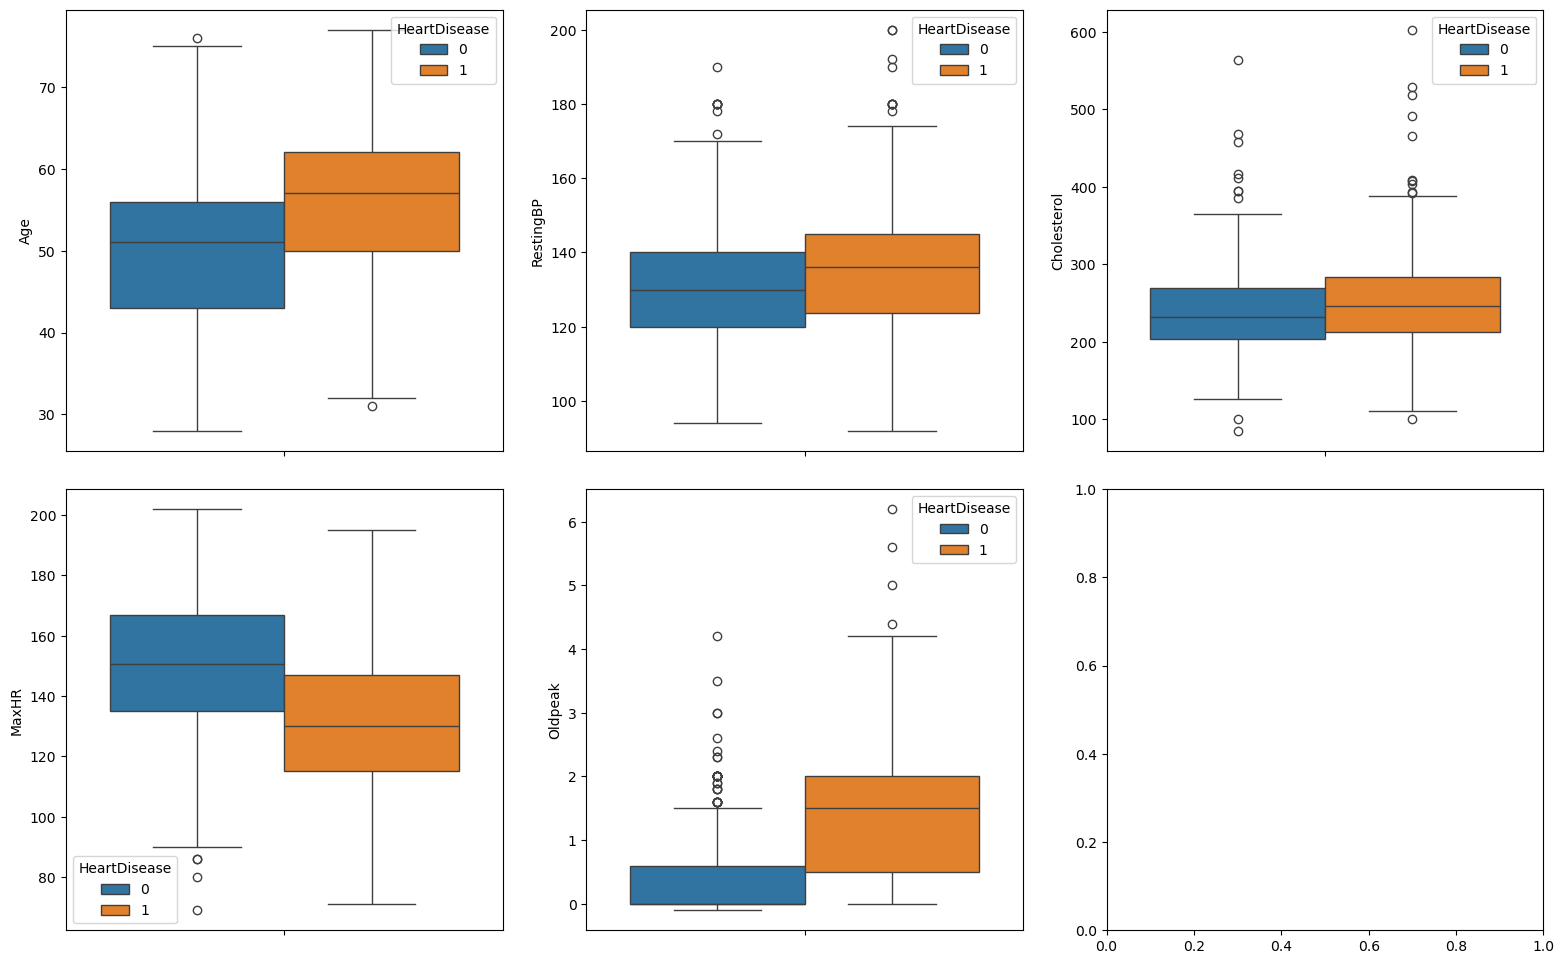

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.boxplot(data=df_clean, y=col, hue="HeartDisease",ax=axs[i // 3, i % 3])

plt.tight_layout(pad=2)

## Frequenze sugli attributi categorici in relazione alla variabile target
Guardando i grafici possiamo dire:
- I maschi si ammalano di più rispetto alle donne
- Nel dataset ci sono molti pazienti che si ammalano con un dolore asintomatico al torace
- Chi ha problemi di glicemia si ammala di più, ma ci sono molti malati anche che non hanno problemi di glicemia
- I valori dell'ECG sono abbastanza bilanciati, chi non ha l'ECG normale ha leggera probabilità di ammalarsi ma la differenza è poca
- Chi ha dolore al petto durante l'esercizio fisico spesso ha malattie cardiache (basandosi sul dataset che ha pazienti già a rischio)
- Chi ha il segmento ST piatto spesso ha malattie cardiache


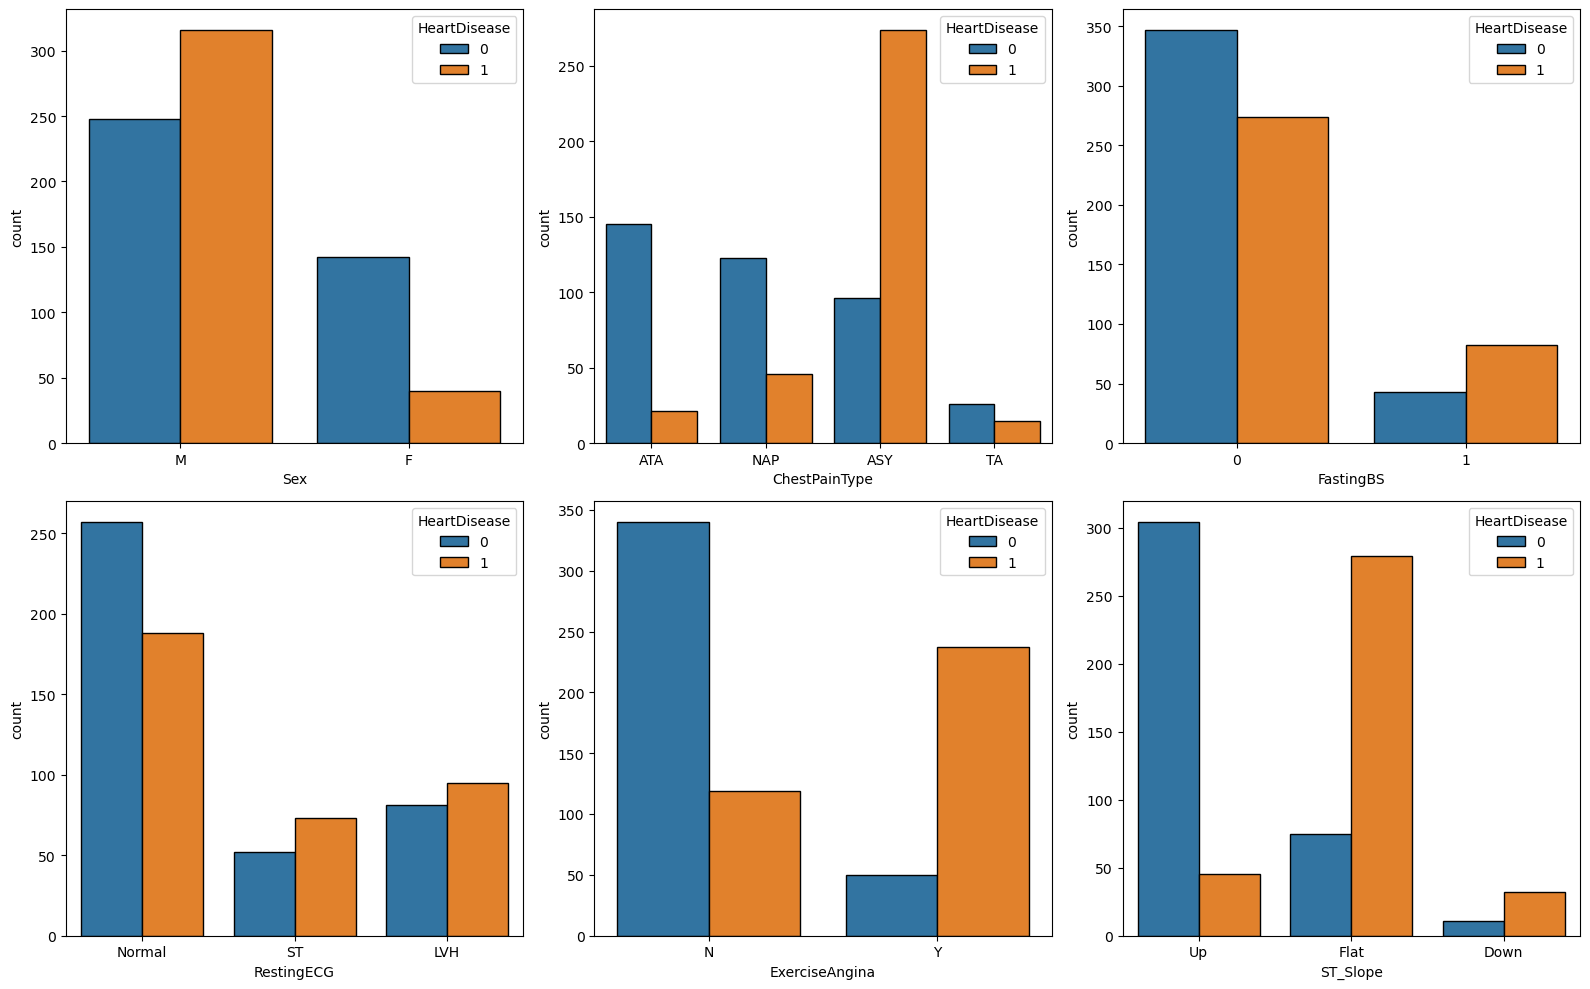

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(categorical):
    sns.countplot(
        df_clean,
        ax=axs[i // 3, i % 3],
        edgecolor="black",
        x=col,
        hue="HeartDisease",
    )
plt.tight_layout()

Mettiamo in relazione
TODO: completare

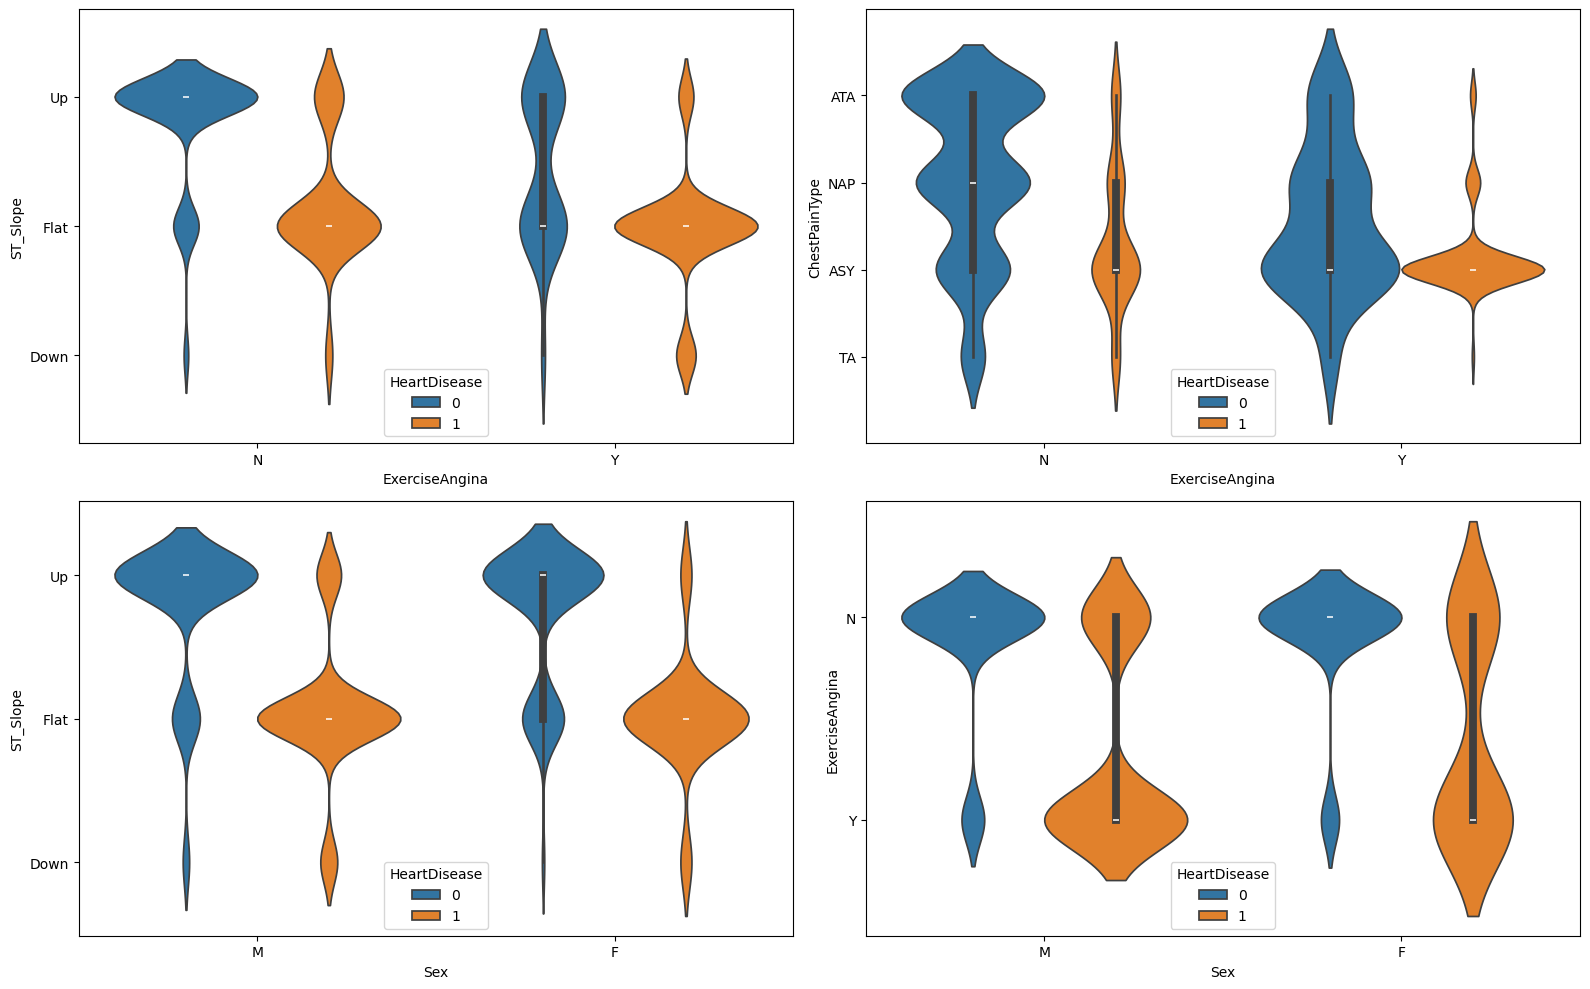

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

comparisons = [
    ("ExerciseAngina","ST_Slope"),
    ("ExerciseAngina", "ChestPainType"),
    ("Sex", "ST_Slope"),
    ("Sex", "ExerciseAngina"),
]

for i, (col1, col2) in enumerate(comparisons):
    sns.violinplot(
        data=df_clean,
        x=col1,
        y=col2,
        hue="HeartDisease",
        ax=axs[i // 2, i % 2],
    )

plt.tight_layout()

# Analisi delle correlazioni

## Correlazioni tra le variabili numeriche
Presentando lo scatterplot possiamo notare che non ci siano particaolari correlazioni molto significative ne tra gli attributi ne con la variabile target.  
Quello che possiamo però dire che OldPeak, MaxHR e Age hanno una relazione con la variabile target più significativa rispetto agli altri attributi

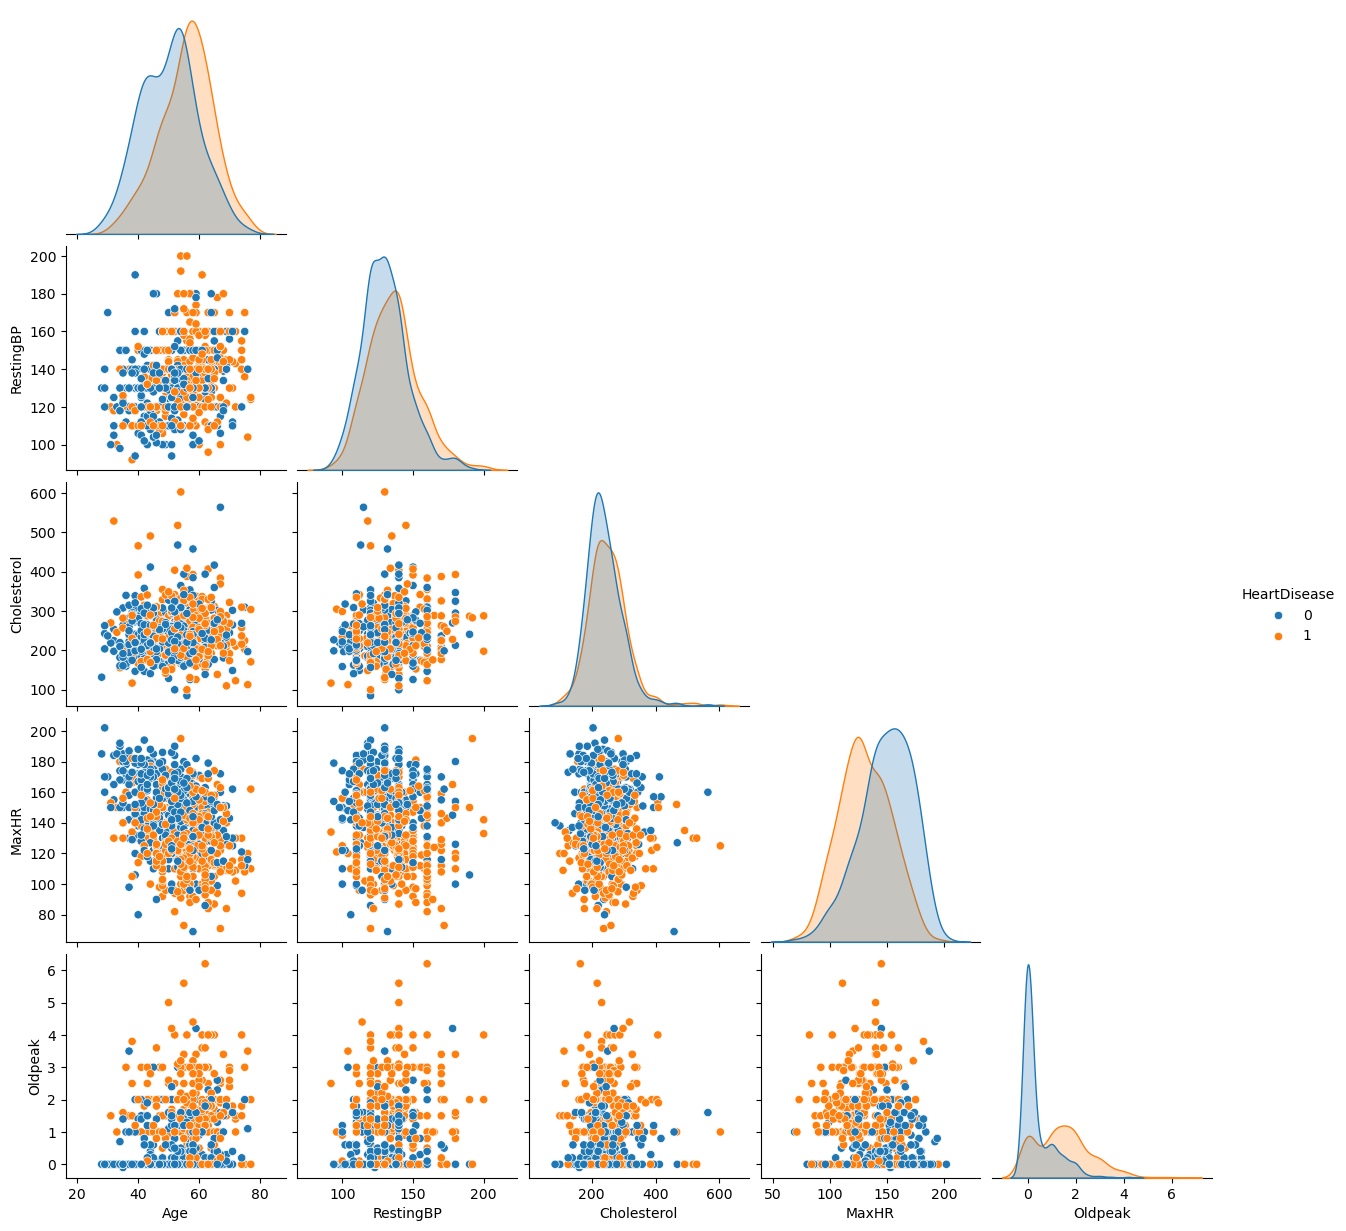

In [28]:
sns.pairplot(
    data=df_clean[numerical + ["HeartDisease"]], hue="HeartDisease", corner=True
)

Correlazione con la variabile target ci indica una dipendenza ordinata in questo modo:
- Valore di Oldpeak (diretta) _alta_
- Frequenza cardiaca massima (inversa) _alta_
- Età (diretta) _media_
- Pressione del sangue (diretta) _bassa_
- Colesterolo (diretta) _bassa_

In [29]:
# point biserial correlation
for col in numerical:
    corr, p = pointbiserialr(df_clean["HeartDisease"], df_clean[col])
    if p < 0.05:
        print(
            f"La correlazione è significativa tra HeartDisease e {col} (correlazione {corr} e p-value {p})"
        )
    else:
        print(
            f"Non possiamo dire nulla sulla correlazione tra HeartDisease e {col} (correlazione {corr} e p-value {p})"
        )

La correlazione è significativa tra HeartDisease e Age (correlazione 0.29861668487267484 e p-value 7.861071765823028e-17)
La correlazione è significativa tra HeartDisease e RestingBP (correlazione 0.17324158155012143 e p-value 1.9373836240386295e-06)
La correlazione è significativa tra HeartDisease e Cholesterol (correlazione 0.10386559562465594 e p-value 0.004514069106741989)
La correlazione è significativa tra HeartDisease e MaxHR (correlazione -0.37721219001674333 e p-value 1.2269260081362859e-26)
La correlazione è significativa tra HeartDisease e Oldpeak (correlazione 0.4956962549378697 e p-value 1.630293971174312e-47)


Guardando la correlazione tra gli attributi numerici possiamo notare le seguenti correlazioni forti:
- Età e Frequenza cardiaca massima (inversa) _lineare_ [alta]
- Età e valore di OldPeak (diretta) _da funzione montona_ [alta]
- OldPeak e Frequenza cardiaca massima (diretta) _da funzione montona_
- Età e pressione sanguigna (diretta) _da funzione montona_

In [30]:
methods = ["pearson", "spearman", "kendall"]
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for i, method in enumerate(methods):
    sns.heatmap(
        df_clean[numerical].corr(method=method),
        annot=True,
        ax=axs[i],
        cmap="coolwarm",
    )
    axs[i].set_title(method)

In [31]:
# Gli attributi con maggiore correlazione hanno un qqplot poco rappresentativo
qqplot(df_clean["Age"], df_clean["MaxHR"], quantiles=100)

/var/folders/x5/xvsgcbj13_s9tdm6w_4zqg9m0000gn/T/ipykernel_57495/1404066045.py:2: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qqplot(df_clean["Age"], df_clean["MaxHR"], quantiles=100)


## Correlazione tra variabili categoriche

#### Calcolo matrice di contingenza

In [32]:
def contingency_table_analysis(df, target, col, ax):
    contingency_table = pd.crosstab(df[target], df[col])
    stat, p, dof, expected = chi2_contingency(contingency_table)

    # print(f"I valori attesi della tabella di contingenza sarebbero:\n {expected}\n")
    print(
        f"Il coefficient di correlazione è {stat} mentre il grado di libertà è {dof}"
    )

    annot = np.empty_like(contingency_table).astype(str)
    for i in range(contingency_table.shape[0]):
        for j in range(contingency_table.shape[1]):
            c = contingency_table.iloc[i, j]
            e = expected[i, j]
            annot[i, j] = f"{c} ({e:.1f})"

    sns.heatmap(contingency_table, annot=annot, fmt="", cmap="coolwarm", ax=ax)

    alpha = 0.05
    print("Il P-value è " + str(p))
    if p <= alpha:
        print("Dependent (reject H0)")
    else:
        print("Independent (H0 holds true)")

### Tabelle di contingenza tra attributi categorici e variabile target
Queste tabelle ci conferma le assunzioni fatte guardando le frequenza degli attributi categorici rispetto alla variabile target. 
In ordine di correlazione più forte:
- Chi sente dolore durante l'esercizio fisico _[alta]_
- Chi ha il segmento di ST piatto _[alta]_
- Chi è maschio _[media]_
- Chi è asintomatico al dolore al petto, stranamente ha più pazienti del dovuto con malattie _[bassa]_
- Chi ha la glicemia _[bassa]_
- La pressione nel sangue ha bassa correlazione


In [33]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(categorical):
    print(f"Analisi per la variabile {col}")
    contingency_table_analysis(df_clean, "HeartDisease", col, axs[i // 3, i % 3])
    print()
    axs[i // 3, i % 3].set_title(col)

plt.tight_layout()

Analisi per la variabile Sex
Il coefficient di correlazione è 62.58908315427757 mentre il grado di libertà è 1
Il P-value è 2.5466116402861146e-15
Dependent (reject H0)

Analisi per la variabile ChestPainType
Il coefficient di correlazione è 215.19039576001538 mentre il grado di libertà è 3
Il P-value è 2.1996576286739657e-46
Dependent (reject H0)

Analisi per la variabile FastingBS
Il coefficient di correlazione è 18.388424831836467 mentre il grado di libertà è 1
Il P-value è 1.8014903238899396e-05
Dependent (reject H0)

Analisi per la variabile RestingECG
Il coefficient di correlazione è 13.819621153250228 mentre il grado di libertà è 2
Il P-value è 0.000997946813034952
Dependent (reject H0)

Analisi per la variabile ExerciseAngina
Il coefficient di correlazione è 224.90775965021905 mentre il grado di libertà è 1
Il P-value è 7.690036188894027e-51
Dependent (reject H0)

Analisi per la variabile ST_Slope
Il coefficient di correlazione è 319.13762270357586 mentre il grado di libertà è 

# Analisi di similarità
Abbiamo notato nelle sezioni precedenti che un paziente è a rischio con queste caratteristiche:
- Oldpeak alto
- Frequenza cardiaca massima bassa
- Dolore durante l'esercizio 
- segmento ST piatto
Calcoliamo la matrice di dissimilarità e cerchiamo i pazienti simili a un paziente con queste caratteristiche.

In [34]:
df_numerical = df_clean.copy()

# Convertiamo attributi binari in numerici
pd.set_option('future.no_silent_downcasting', True)
df_numerical["Sex"]=df_numerical["Sex"].replace({"F": 0, "M": 1})
df_numerical["ExerciseAngina"]=df_numerical["ExerciseAngina"].replace({"N": 0, "Y": 1})

# Scaliamo i valori numerici
for col in numerical:
    df_numerical[col] = (df_numerical[col] - df_numerical[col].min()) / (df_numerical[col].max() - df_numerical[col].min())

# Non consideriamo gli attributi categorici non ordinabili
df_numerical.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0  0.244898   1           ATA   0.444444     0.393822          0     Normal   
1  0.428571   0           NAP   0.629630     0.183398          0     Normal   
2  0.183673   1           ATA   0.351852     0.382239          0         ST   
3  0.408163   0           ASY   0.425926     0.249035          0     Normal   
4  0.530612   1           NAP   0.537037     0.212355          0     Normal   

      MaxHR ExerciseAngina   Oldpeak ST_Slope  HeartDisease  
0  0.774436              0  0.015873       Up             0  
1  0.654135              0  0.174603     Flat             1  
2  0.218045              0  0.015873       Up             0  
3  0.293233              1  0.253968     Flat             1  
4  0.398496              0  0.015873       Up             0

In [35]:
df_numerical.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  746.000000  746.000000   746.000000  746.000000  746.000000   
mean     0.507797    0.379841     0.308176    0.167560    0.535538   
std      0.193998    0.160025     0.114196    0.373726    0.184392   
min      0.000000    0.000000     0.000000    0.000000    0.000000   
25%      0.367347    0.259259     0.236004    0.000000    0.398496   
50%      0.530612    0.351852     0.293436    0.000000    0.533835   
75%      0.632653    0.444444     0.366795    0.000000    0.684211   
max      1.000000    1.000000     1.000000    1.000000    1.000000   

          Oldpeak  HeartDisease  
count  746.000000    746.000000  
mean     0.158985      0.477212  
std      0.170295      0.499816  
min      0.000000      0.000000  
25%      0.015873      0.000000  
50%      0.095238      0.000000  
75%      0.253968      1.000000  
max      1.000000      1.000000

In [36]:
dict_types = {
    "Age": "NU",
    "Sex": "SB",
    "RestingBP": "NU",
    "Cholesterol": "NU",
    "FastingBS": "AB",
    "MaxHR": "NU",
    "ExerciseAngina": "AB",
    "Oldpeak": "NU",
    "HeartDisease": "AB"
}

diss_matrix = dissimilarity_matrix(df_numerical, dict_types)

Record 0/746
Record 1/746
Record 2/746
Record 3/746
Record 4/746
Record 5/746
Record 6/746
Record 7/746
Record 8/746
Record 9/746
Record 10/746
Record 11/746
Record 12/746
Record 13/746
Record 14/746
Record 15/746
Record 16/746
Record 17/746
Record 18/746
Record 19/746
Record 20/746
Record 21/746
Record 22/746
Record 23/746
Record 24/746
Record 25/746
Record 26/746
Record 27/746
Record 28/746
Record 29/746
Record 30/746
Record 31/746
Record 32/746
Record 33/746
Record 34/746
Record 35/746
Record 36/746
Record 37/746
Record 38/746
Record 39/746
Record 40/746
Record 41/746
Record 42/746
Record 43/746
Record 44/746
Record 45/746
Record 46/746
Record 47/746
Record 48/746
Record 49/746
Record 50/746
Record 51/746
Record 52/746
Record 53/746
Record 54/746
Record 55/746
Record 56/746
Record 57/746
Record 58/746
Record 59/746
Record 60/746
Record 61/746
Record 62/746
Record 63/746
Record 64/746
Record 65/746
Record 66/746
Record 67/746
Record 68/746
Record 69/746
Record 70/746
Record 71/746
Re

In [37]:
# Cerchiamo tra i pazienti con oldpeak alto, frequenza cardiaca massima bassa, dolore durante l'esercizio e segmento ST piatto
patients_at_risk = df_numerical[(df_numerical["Oldpeak"] > 0.5) & (df_numerical["MaxHR"] < 0.5) & (df_numerical["ExerciseAngina"] == 1) & (df_numerical["ST_Slope"] == "Flat")]
patients_at_risk

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
68   0.489796   1           ASY   0.629630     0.310811          0         ST   
671  0.673469   1           ASY   0.425926     0.156371          0        LVH   
725  0.551020   0           ASY   0.814815     0.467181          0         ST   
736  0.530612   1           ASY   0.277778     0.388031          0        LVH   
791  0.469388   1           ASY   0.444444     0.411197          0     Normal   

        MaxHR ExerciseAngina   Oldpeak ST_Slope  HeartDisease  
68   0.097744              1  0.650794     Flat             1  
671  0.421053              1  0.587302     Flat             1  
725  0.360902              1  0.555556     Flat             1  
736  0.353383              1  0.523810     Flat             1  
791  0.398496              1  0.682540     Flat             1

In [38]:
# Prendiamo l'indice del primo paziente a rischio
patients_at_risk.iloc[0].name

68

In [39]:
# Ordiniamo i pazienti dal più simile al meno simile al paziente a rischio
most_similar=diss_matrix.loc[patients_at_risk.iloc[0].name].sort_values().index[0:]
df_sample=df_clean.loc[most_similar,:]
df_sample

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
68    52   M           ASY      160.0        246.0          0         ST   
111   57   M           ASY      150.0        255.0          0     Normal   
140   52   M           ASY      160.0        331.0          0     Normal   
239   48   M           ASY      160.0        193.0          0     Normal   
569   55   M           ASY      158.0        217.0          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
126   34   F           ATA      130.0        161.0          0     Normal   
271   32   F           ATA      105.0        198.0          0     Normal   
118   35   F            TA      120.0        160.0          0         ST   
616   67   F           NAP      115.0        564.0          0        LVH   
692   39   F           NAP       94.0        199.0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
68      82              Y      4.0     Flat             1  
111     92              Y      3.0     Flat             1  
140     94              Y      2.5     Flat             1  
239    102              Y      3.0     Flat             1  
569    110              Y      2.5     Flat             1  
..     ...            ...      ...      ...           ...  
126    190              N      0.0       Up             0  
271    165              N      0.0       Up             0  
118    185              N      0.0       Up             0  
616    160              N      1.6     Flat             0  
692    179              N      0.0       Up             0  

[746 rows x 12 columns]

In [40]:
# Notiamo che il paziente più simile sano è il 170-esimo e il secondo è il 204-esimo
df_sample.reset_index(drop=True, inplace=True)
df_sample[df_sample["HeartDisease"]==0].head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
170   53   M           ASY      124.0        260.0          0         ST   
204   57   M           ASY      130.0        207.0          0         ST   
207   55   M           ASY      140.0        229.0          0     Normal   
212   53   M           ASY      142.0        226.0          0        LVH   
223   51   M            TA      125.0        213.0          0        LVH   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
170    112              Y      3.0     Flat             0  
204     96              Y      1.0     Flat             0  
207    110              Y      0.5     Flat             0  
212    111              Y      0.0       Up             0  
223    125              Y      1.4       Up             0

# Missing values
Riempiamo i valori nulli di colesterolo e della pressione del sangue trovati in una delle sezioni precedenti.  
Per farlo utilizzeremo un metodo che riempe i valori basandosi sulla similarità.

In [41]:
df_imputed = df.copy()
df_imputed[col_with_zeros] = df_imputed[col_with_zeros].replace(0, np.nan)

In [42]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       917 non-null    float64
 4   Cholesterol     746 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 86.2+ KB


Per riempire i valori mancanti del colesterolo e della pressione sanguigna utilizziamo l'algoritmo dei minimi vicini, ipotizzando che pazienti simili abbiano anche valori simili.

In [43]:
imputer = KNNImputer(n_neighbors=10)
df_imputed[col_with_zeros]=imputer.fit_transform(df_imputed[col_with_zeros])

Guardiamo come è cambiato il dataset.  
Osservando gli attributi categorici, il dataset sembra tornato alle forme originali.

In [44]:
sns.countplot(df_imputed, x="HeartDisease",hue="HeartDisease", edgecolor="black")
sns.countplot(
    df_clean, x="HeartDisease", fill=False, edgecolor="red", legend=False
)

<Axes: xlabel='HeartDisease', ylabel='count'>

In [45]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(categorical):   
    sns.countplot(
        df_imputed,
        x=col,
        ax=axs[i // 3, i % 3],
        edgecolor="black",
        hue=col,
        legend=False,
    )
    sns.countplot(df_clean, x=col, ax=axs[i // 3, i % 3], fill=False, edgecolor="red")
plt.tight_layout()

Osservando gli attributi numerici notiamo che la forma delle distribuzioni si è mantenuta.  

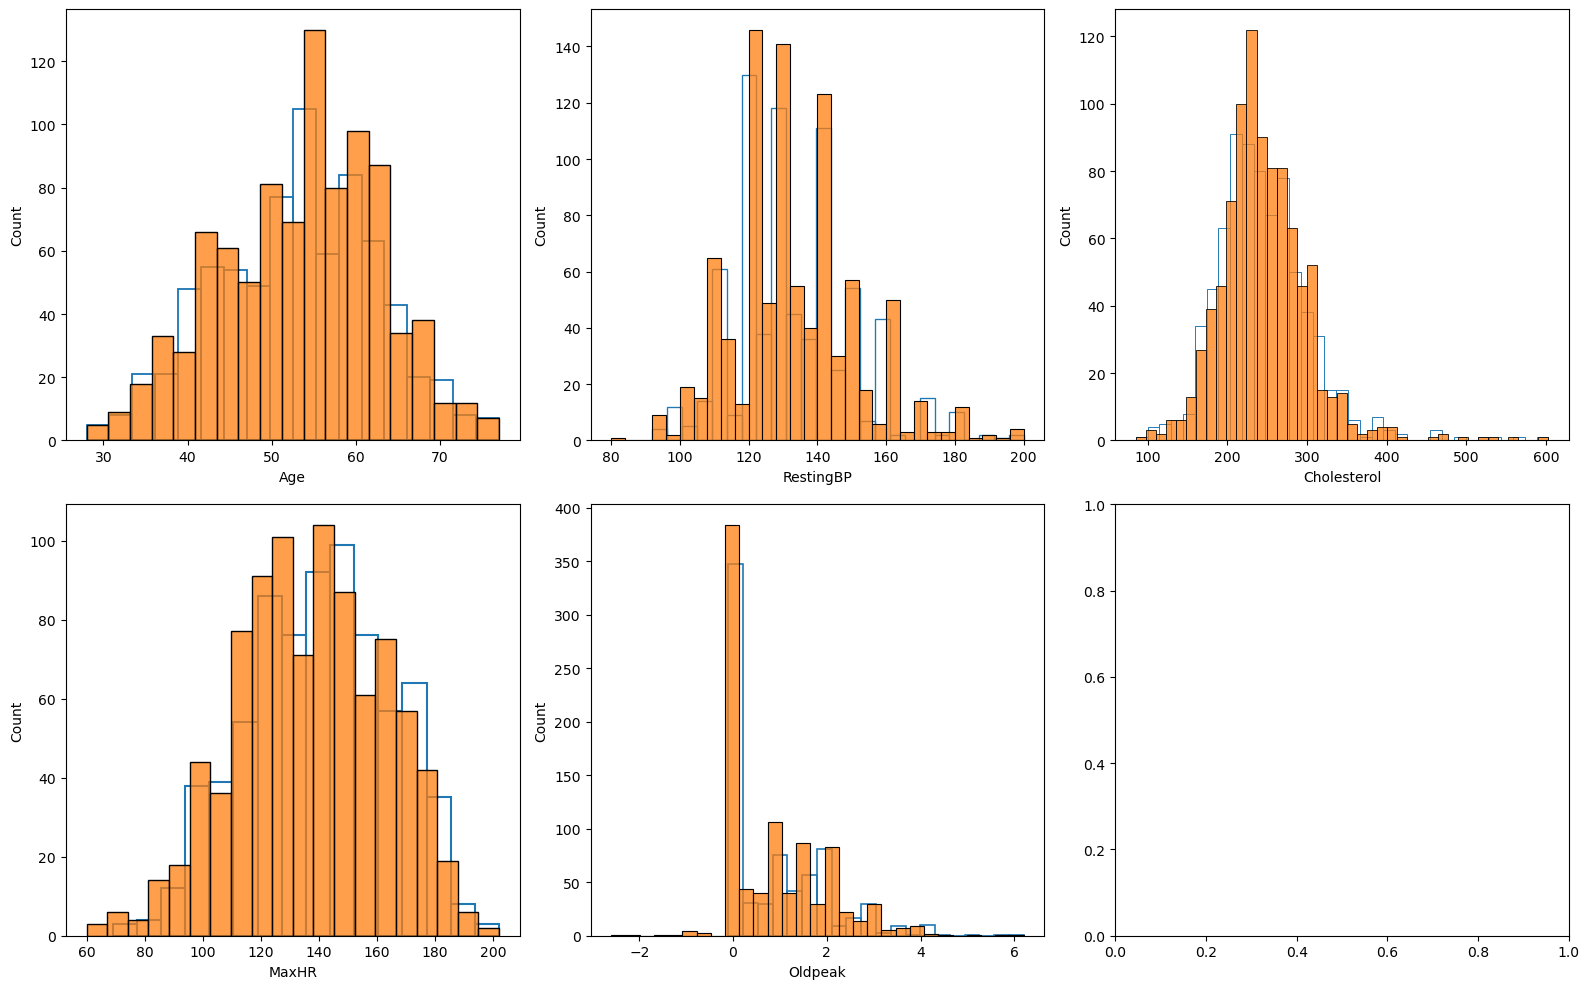

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.histplot(df_clean, x=col, fill=False, ax=axs[i // 3, i % 3])
    sns.histplot(df_imputed, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

Osservando la kde delle distribuzioni notiamo molta similarità con il dataset originale, però ora non abbiamo valori di colesterolo pari a 0.

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.kdeplot(df_clean, x=col, fill=False, ax=axs[i // 3, i % 3])
    sns.kdeplot(df_imputed, x=col, ax=axs[i // 3, i % 3])
plt.tight_layout()

Guardando le matrici di correlazione degli attributi numerici, notiamo che le relazioni tra le variabili sono rimaste quasi le stesse.

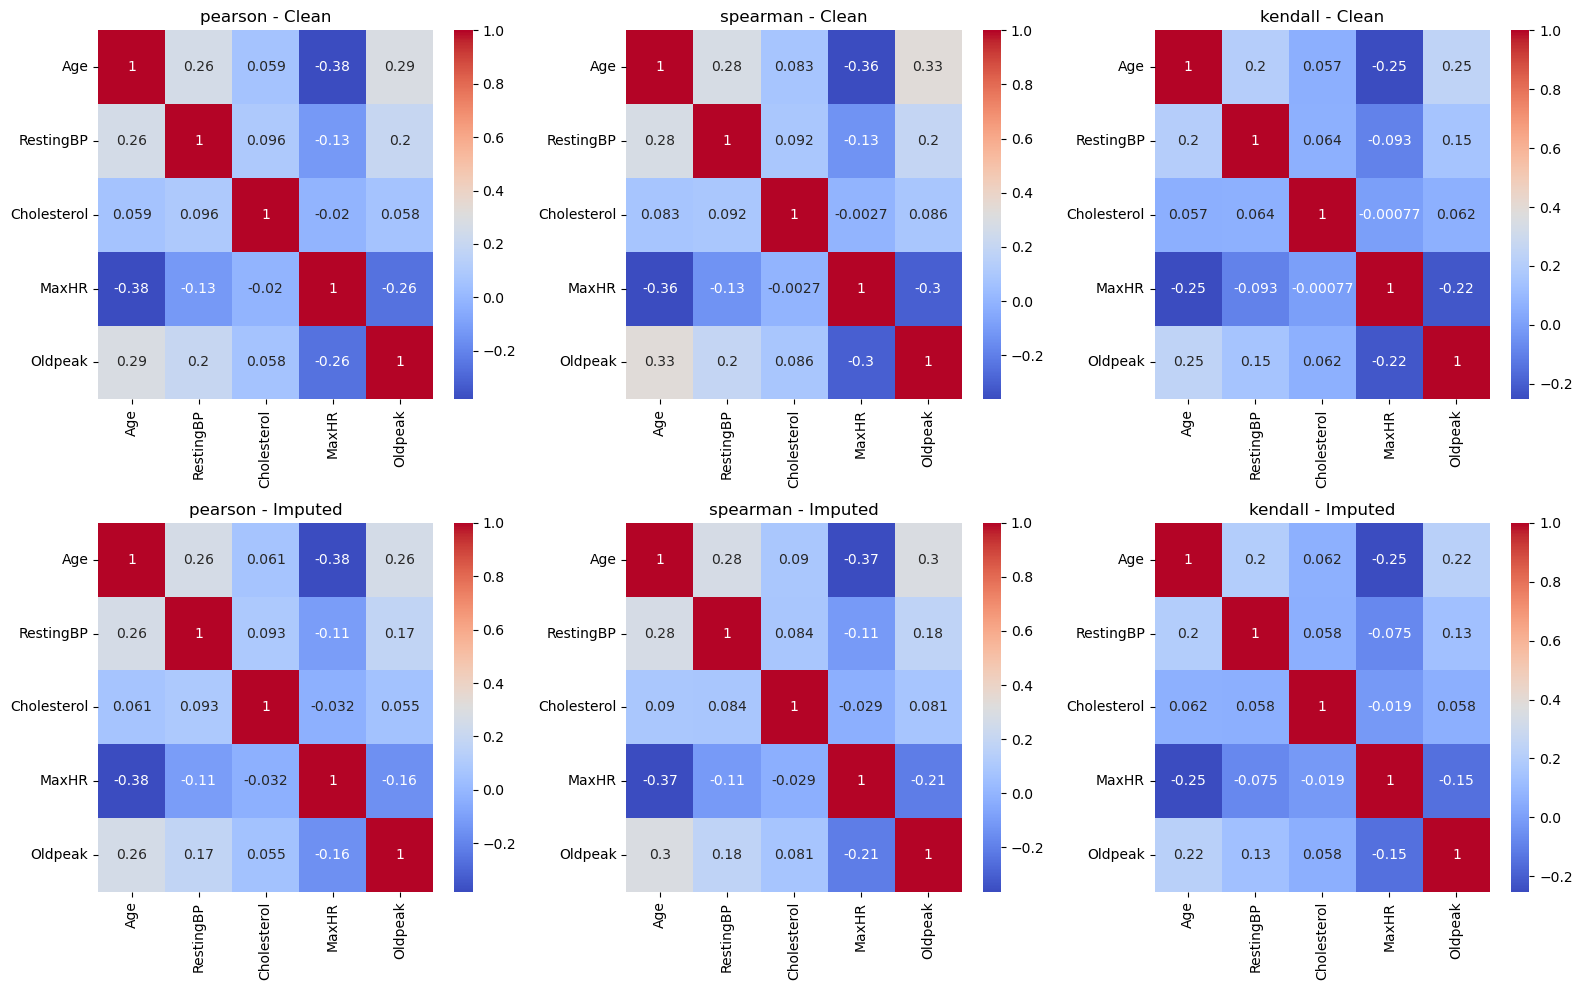

In [48]:
methods = ["pearson", "spearman", "kendall"]
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, method in enumerate(methods):
    sns.heatmap(
        df_clean[numerical].corr(method=method),
        annot=True,
        ax=axs[0,i],
        cmap="coolwarm",
    )
    axs[0,i].set_title(f"{method} - Clean")
    sns.heatmap(
        df_imputed[numerical].corr(method=method),
        annot=True,
        ax=axs[1,i],
        cmap="coolwarm",
    )
    axs[1,i].set_title(f"{method} - Imputed")
plt.tight_layout()

# Outliers
Analizziamo gli outliers delle distribuzioni numeriche.
Osservando i boxplot delle distribuzioni:
- L'età e la frequenza cardiaca massima sembrano non avere outlier
- RestingBP, Cholesterol e Oldpeak invece sembrano avere abbastanza outlier

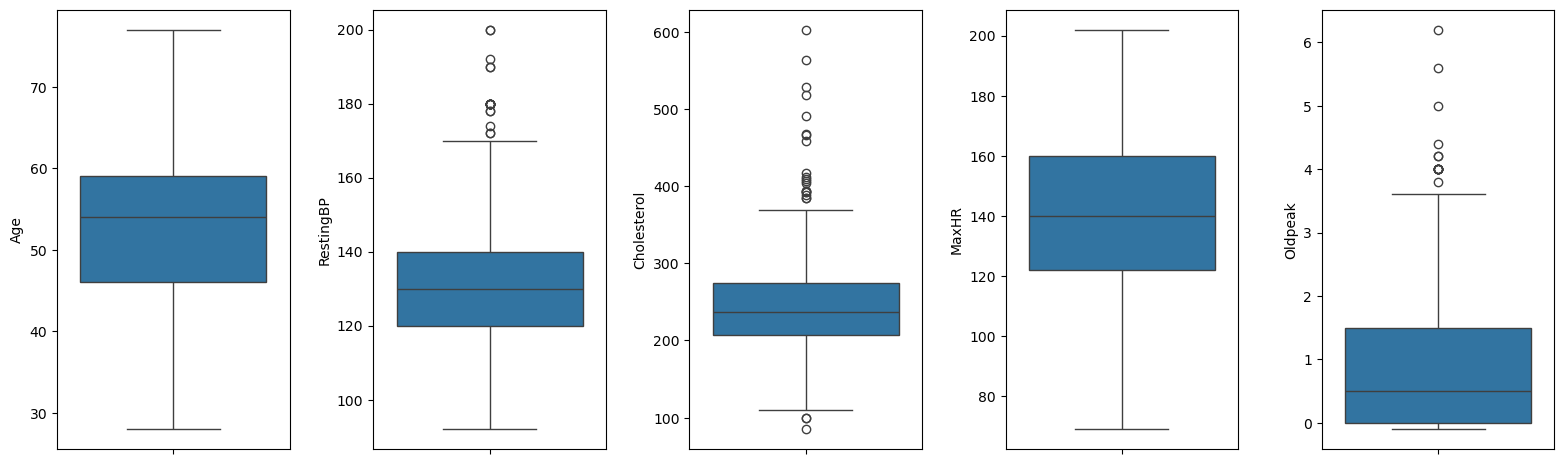

In [49]:
fig, axs = plt.subplots(1,5, figsize=(16, 5))

for i, col in enumerate(numerical):
    sns.boxplot(data=df_clean, y=col, ax=axs[i])

plt.tight_layout(pad=2)

Anche guardando il pairplot si possono notare alcuni pallini che si trovano in una posizione totalmente diversa dall'andamento dei dati.  
Non si tratta quindi solo di rumore.

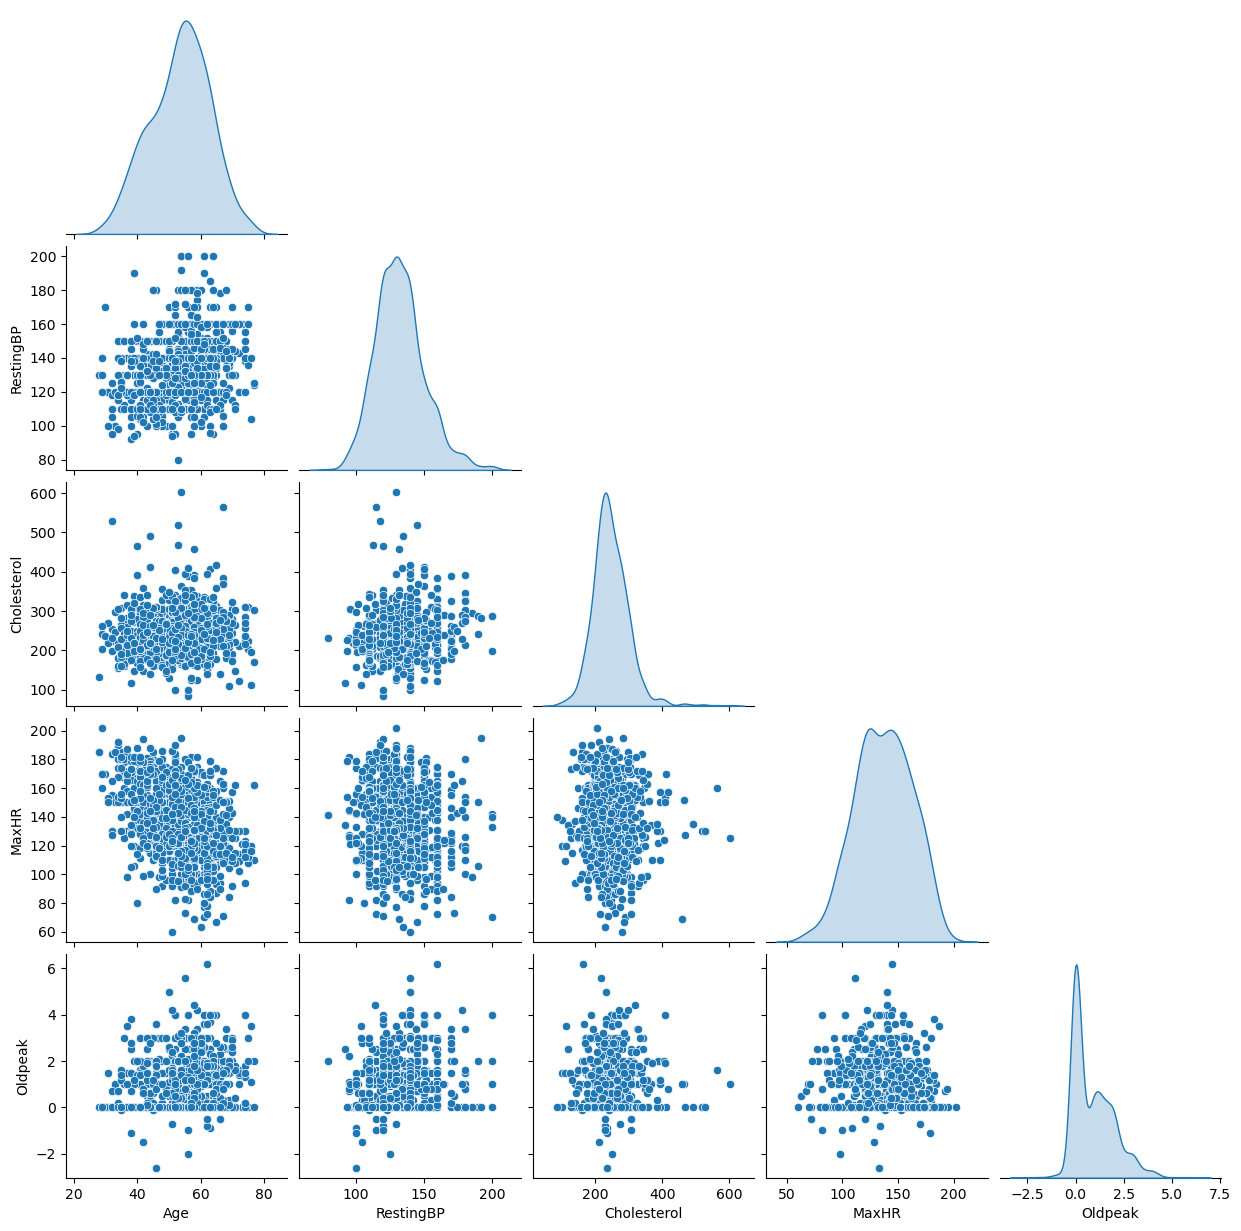

In [50]:
sns.pairplot(
    data=df_imputed[numerical], corner=True, diag_kind="kde"
)

In [51]:
# Scaliamo i valori numerici per lavorare con dati normalizzati
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed[numerical]))
df_scaled.columns = numerical

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.histplot(df_imputed, x=col, fill=False, ax=axs[i // 3, i % 3])
    sns.histplot(df_scaled, x=col, ax=axs[i // 3, i % 3])

plt.tight_layout()

Per identificare gli outliers utilizziamo il metodo DBSCAN.  
Per trovare un epsilon adeguata usiamo il K-distance graph.

In [53]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,-1]

plt.figure(figsize=(6,4))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14,color='k')
epsilon = 1.2
plt.hlines(epsilon,1000,400)
plt.text(200, epsilon, f"Epsilon {epsilon}", ha ='left', va ='center')
plt.show()

Il numero di min_sample è stato configurato con 10, perchè gli attributi considerati sono 5.  
Notiamo che questo metodo ha trovato una trentina di outliers.

In [54]:
model = DBSCAN(eps = epsilon, min_samples = 10).fit(df_scaled)
labels = model.labels_
outliers_DBSCAN=(labels==-1).astype(int)

# Calcoliamo il numero di outliers
unique_values, counts = np.unique(labels, return_counts=True)
value_counts = dict(zip(unique_values, counts))

print("Value Counts:")
for value, count in value_counts.items():
    print(f"{value}: {count}")

Value Counts:
-1: 89
0: 829


Osservando il pairplot notiamo che l'algoritmo in genere ha selezionato i punti in una posizione abbastanza diversa dagli altri.

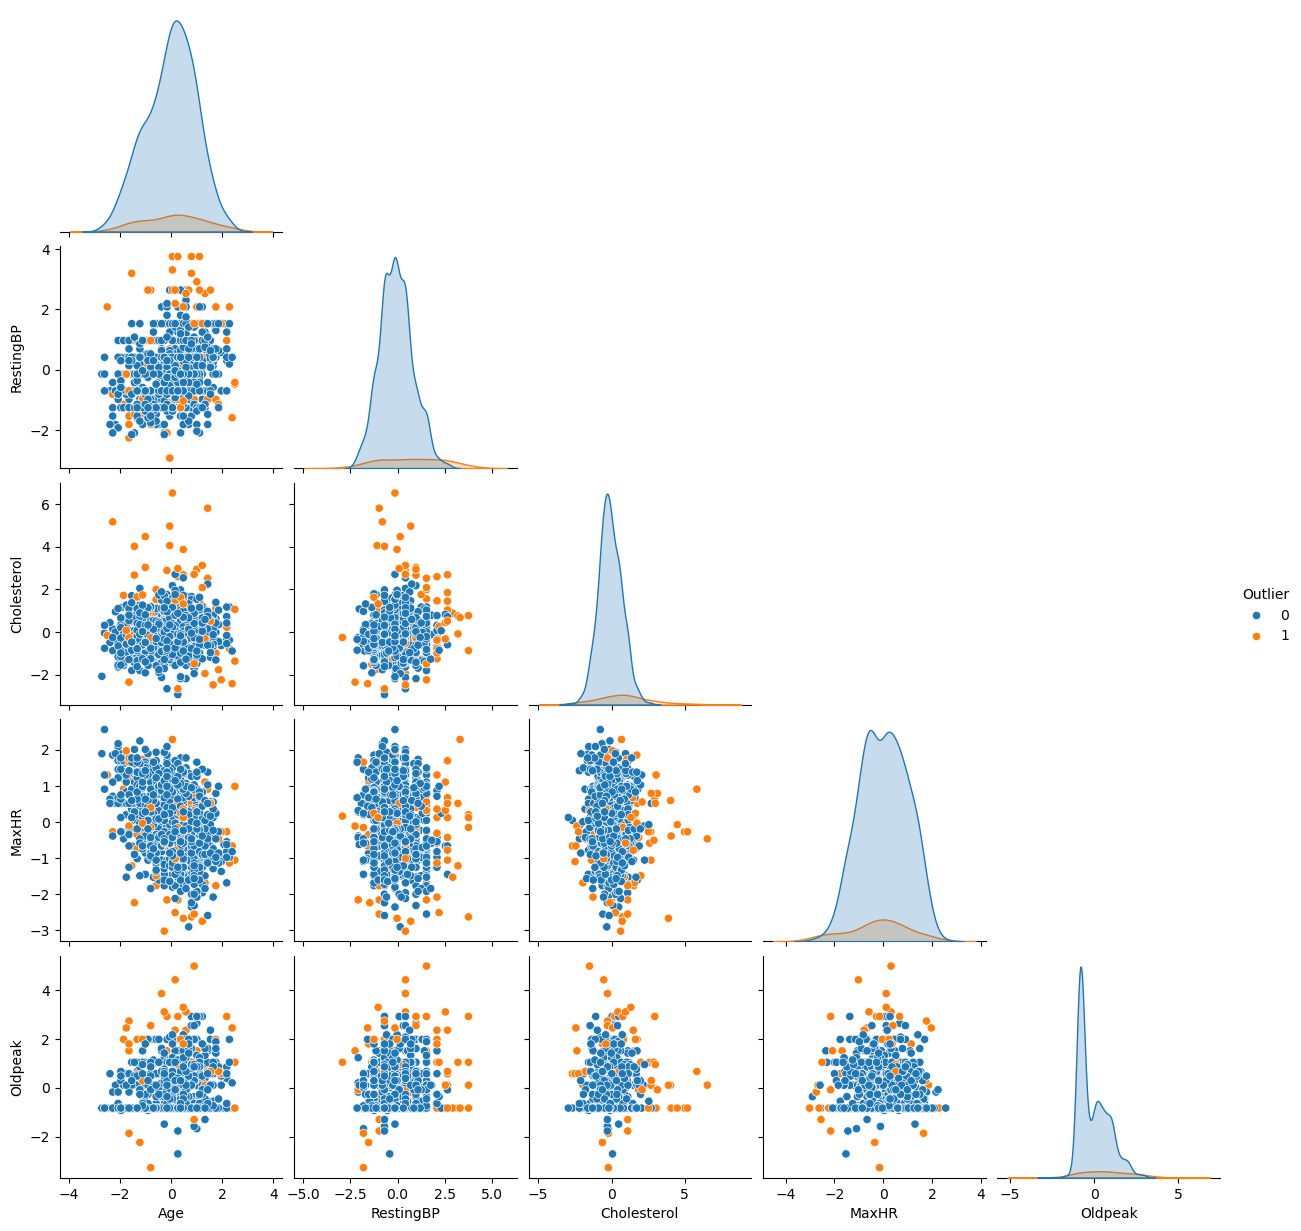

In [55]:
df_scaled["Outlier"] = np.where(outliers_DBSCAN==0, 0, 1)
sns.pairplot(data=df_scaled,corner=True,diag_kind='kde',hue="Outlier")

In [56]:
# Prendiamo i dati senza outliers
df_no_outliers= df_imputed[df_scaled["Outlier"]==0]

Riguardando i boxplot, notiamo che una gran parte di outlier, soprattuto nel colesterole è stata tolta.

Variabile AGE: da [47.0 - 60.0] a [47.0 - 60.0]

Variabile RestingBP: da [120.0 - 140.0] a [120.0 - 140.0]

Variabile Cholesterol: da [213.0 - 274.75] a [212.0 - 271.0]

Variabile MaxHR: da [120.0 - 156.0] a [120.0 - 156.0]

Variabile Oldpeak: da [0.0 - 1.5] a [0.0 - 1.5]



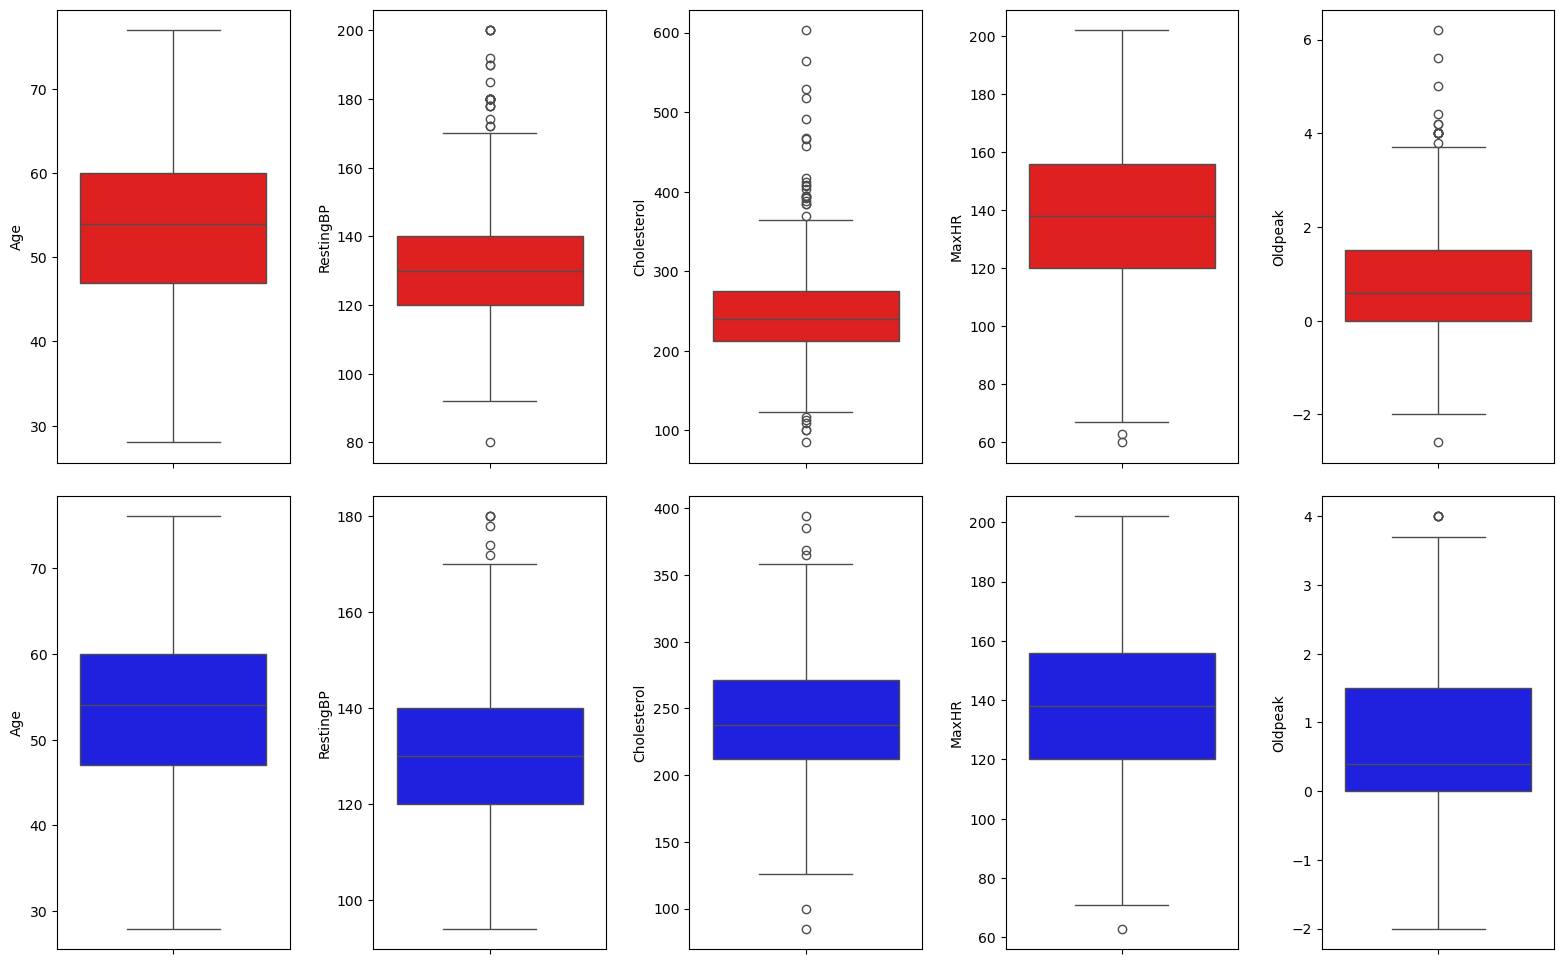

In [57]:
fig, axs = plt.subplots(2,5, figsize=(16, 10))

for i, col in enumerate(numerical):
    sns.boxplot(data=df_imputed, y=col, ax=axs[0,i], color="red")
    sns.boxplot(data=df_no_outliers, y=col, ax=axs[1,i], color="blue")

plt.tight_layout(pad=2)

print(f"Variabile AGE: da [{df_imputed['Age'].quantile(0.25)} - {df_imputed['Age'].quantile(0.75)}] a [{df_no_outliers['Age'].quantile(0.25)} - {df_no_outliers['Age'].quantile(0.75)}]\n")
print(f"Variabile RestingBP: da [{df_imputed['RestingBP'].quantile(0.25)} - {df_imputed['RestingBP'].quantile(0.75)}] a [{df_no_outliers['RestingBP'].quantile(0.25)} - {df_no_outliers['RestingBP'].quantile(0.75)}]\n")
print(f"Variabile Cholesterol: da [{df_imputed['Cholesterol'].quantile(0.25)} - {df_imputed['Cholesterol'].quantile(0.75)}] a [{df_no_outliers['Cholesterol'].quantile(0.25)} - {df_no_outliers['Cholesterol'].quantile(0.75)}]\n")
print(f"Variabile MaxHR: da [{df_imputed['MaxHR'].quantile(0.25)} - {df_imputed['MaxHR'].quantile(0.75)}] a [{df_no_outliers['MaxHR'].quantile(0.25)} - {df_no_outliers['MaxHR'].quantile(0.75)}]\n")
print(f"Variabile Oldpeak: da [{df_imputed['Oldpeak'].quantile(0.25)} - {df_imputed['Oldpeak'].quantile(0.75)}] a [{df_no_outliers['Oldpeak'].quantile(0.25)} - {df_no_outliers['Oldpeak'].quantile(0.75)}]\n")

Guardando il pairplot la forma dei dati si è mantenuta, con meno outliers.

In [58]:
sns.pairplot(data=df_no_outliers[numerical + ["HeartDisease"]], hue="HeartDisease", corner=True)

Anche guardando le matrici di correlazione, vediamo che la relazione tra le variabili si è mantenuta.

In [59]:
methods = ["pearson", "spearman", "kendall"]
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, method in enumerate(methods):
    sns.heatmap(
        df_imputed[numerical].corr(method=method),
        annot=True,
        ax=axs[0,i],
        cmap="coolwarm",
    )
    axs[0,i].set_title(f"{method} - with Outliers")
    sns.heatmap(
        df_no_outliers[numerical].corr(method=method),
        annot=True,
        ax=axs[1,i],
        cmap="coolwarm",
    )
    axs[1,i].set_title(f"{method} - no Outliers")
plt.tight_layout()

# Modello di classificazione
Infine concludiamo lo studio applicando un algoritmo di Machine Learning, in particolare il Random Forest.

## Prepariamo i dati

In [60]:
data_to_model = df_no_outliers.copy()
data_to_model["Sex"] = data_to_model["Sex"].replace({"F": 0, "M": 1})
data_to_model["ExerciseAngina"] = data_to_model["ExerciseAngina"].replace({"N": 0, "Y": 1})

data_to_model = pd.get_dummies(data_to_model,columns=["ChestPainType"],drop_first=True,dtype='i')
data_to_model = pd.get_dummies(data_to_model,columns=["RestingECG"],drop_first=True,dtype='i')
data_to_model = pd.get_dummies(data_to_model,columns=["ST_Slope"],drop_first=True,dtype='i')

In [61]:
data_to_model.head()

Age Sex  RestingBP  Cholesterol  FastingBS  MaxHR ExerciseAngina  Oldpeak  \
0   40   1      140.0        289.0          0    172              0      0.0   
1   49   0      160.0        180.0          0    156              0      1.0   
2   37   1      130.0        283.0          0     98              0      0.0   
3   48   0      138.0        214.0          0    108              1      1.5   
4   54   1      150.0        195.0          0    122              0      0.0   

   HeartDisease  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0             0                  1                  0                 0   
1             1                  0                  1                 0   
2             0                  1                  0                 0   
3             1                  0                  0                 0   
4             0                  0                  1                 0   

   RestingECG_Normal  RestingECG_ST  ST_Slope_Flat  ST_Slope_Up  
0                  1              0              0            1  
1                  1              0              1            0  
2                  0              1              0            1  
3                  1              0              1            0  
4                  1              0              0            1

## Classificazione

In [62]:
# Dividiamo il dataset in train e test set
data_train, data_test = train_test_split(data_to_model, test_size=0.3, random_state=0)
x_train, y_train = data_train.drop(columns=["HeartDisease"]), data_train["HeartDisease"]
x_test, y_test = data_test.drop(columns=["HeartDisease"]), data_test["HeartDisease"]

In [63]:
# Scaliamo i dati per lavorare con valori normalizzati
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [64]:
# Cerchiamo i migliori parametri per il modello
grid = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1,random_state=0), {'n_estimators': range(100, 500), 'max_depth': range(50,100), 'criterion':[ 'entropy', 'log_loss']}, n_iter=50, n_jobs=-1,random_state=0, cv=5)
search_params = grid.fit(x_train, y_train)
search_params.best_params_

{'n_estimators': 252, 'max_depth': 60, 'criterion': 'log_loss'}

In [65]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_estimators","param_max_depth","param_criterion","mean_fit_time","mean_test_score"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

In [66]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_estimators')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
best_n_estimators = best.param_n_estimators
best_max_depth = best.param_max_depth
best_criterion = best.param_criterion
ax[0].scatter(best.param_n_estimators, best.mean_test_score, color='red')
ax[0].set_ylim(0.8,1)

sns.lineplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di n_estimators')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1])
ax[1].scatter(best.param_n_estimators, best.mean_fit_time, color='red')
ax[1].set_ylim(0,5)

(0.0, 5.0)

Avendo trovati i migliori iperparatri per il modello, misuriamo le sue metriche di performance

In [67]:
rf = RandomForestClassifier(n_estimators=best_n_estimators,max_depth=best_max_depth,criterion=best_criterion, random_state=0)
rf.fit(x_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=53, n_estimators=268,
                       random_state=0)

In [68]:
y_pred = rf.predict(x_test)

In [69]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8795180722891566


In [70]:
# Notiamo che la recall per la classe 1 è abbastanza alta, il che è un buon segno. Riusciamo a prevedere meglio i pazienti malati.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       118
           1       0.86      0.92      0.89       131

    accuracy                           0.88       249
   macro avg       0.88      0.88      0.88       249
weighted avg       0.88      0.88      0.88       249



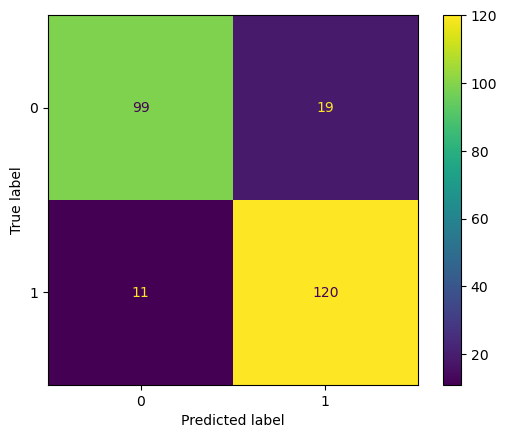

In [71]:
# Anche la matrice di confusione ci mostra che il modello è in grado di prevedere meglio i pazienti malati
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# Conclusioni
In conclusione abbiamo studiato il dataset in tutti i suoi aspetti, abbiamo trovato i valori più rilevanti per prevedere una probabile malattia cardiaca.  
In generale il dataset ci fornisce attributi abbastanza indipendenti tra loro che cercano di rappresentare al meglio la situazione del paziente. Ovviamente questo è un caso molto più semplice della realtà e soprattuto il dataset non era per niente sbilanciato come si potrebbe trovare nella realtà.
Infine è stato addestrato anche un semplice modello di Machine Learning che ha riscontrato performance accettabili, grazie alla qualità dei dati.